# Installation et importation des bibliothèques

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from scipy.stats import pointbiserialr, ks_2samp, shapiro
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import hyperopt
from hyperopt import hp, tpe, fmin, Trials
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.base import clone
import shap
import optuna
from sklearn.inspection import permutation_importance


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Chargement des données

In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Analyse exploratoire des données

In [ ]:
train.head()

id  CustomerId    Surname  CreditScore Geography  Gender   Age  Tenure  \
0   0  15713774.0      Hsieh        683.0   Germany    Male  49.0     7.0   
1   1  15682533.0      Hs?eh        608.0    France  Female  30.0    10.0   
2   2  15791550.0       Tsou        539.0    France  Female  32.0     8.0   
3   3  15762762.0  Chiawuotu        530.0     Spain  Female  39.0     8.0   
4   4  15756475.0     Nnamdi        613.0    France  Female  45.0    10.0   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0  123837.86            2.0        1.0             1.0        138700.75   
1       0.00            2.0        1.0             1.0        146723.72   
2       0.00            1.0        1.0             1.0         94873.60   
3       0.00            2.0        0.0             0.0        177896.93   
4       0.00            2.0        1.0             1.0        116748.14   

   Exited  
0     1.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

In [ ]:
train.describe()


id    CustomerId   CreditScore           Age        Tenure  \
count  15000.000000  1.500000e+04  15000.000000  15000.000000  15000.000000   
mean    7499.500000  1.570073e+07    658.701800     37.660800      5.038800   
std     4330.271354  1.162730e+06     80.238346      8.106408      2.810354   
min        0.000000  1.557151e+05    431.000000     18.000000      0.000000   
25%     3749.750000  1.563387e+07    602.000000     32.000000      3.000000   
50%     7499.500000  1.569018e+07    661.000000     37.000000      5.000000   
75%    11249.250000  1.575972e+07    709.000000     42.000000      7.000000   
max    14999.000000  1.562648e+08   4818.000000     72.000000     10.000000   

             Balance  NumOfProducts     HasCrCard  IsActiveMember  \
count   15000.000000   15000.000000  15000.000000    15000.000000   
mean    42888.826095       1.589467      0.779800        0.497867   
std     59695.877791       0.532430      0.414395        0.500012   
min         0.000000       1.000000      0.000000        0.000000   
25%         0.000000       1.000000      1.000000        0.000000   
50%         0.000000       2.000000      1.000000        0.000000   
75%    109844.810000       2.000000      1.000000        1.000000   
max    207034.960000       6.000000      1.000000        1.000000   

       EstimatedSalary        Exited  
count     15000.000000  15000.000000  
mean     117892.175400      0.199333  
std       45574.462515      0.399512  
min          11.580000      0.000000  
25%       82870.750000      0.000000  
50%      123583.850000      0.000000  
75%      157567.370000      0.000000  
max      199761.290000      1.000000

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [ ]:
test.head()

id  CustomerId    Surname  CreditScore Geography  Gender   Age  Tenure  \
0  15000  15797736.0  Chikwendu        591.0   Germany  Female  32.0     2.0   
1  15001  15676515.0        Lai        553.0     Spain    Male  37.0     2.0   
2  15002  15701291.0   Folliero        646.0    France  Female  29.0     7.0   
3  15003  15594812.0  Trevisani        603.0   Germany    Male  49.0     8.0   
4  15004  15791321.0     Ch'ien        645.0     Spain  Female  39.0     3.0   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  
0  106881.50            2.0        1.0             0.0        122810.53  
1       0.00            2.0        1.0             0.0         63736.17  
2       0.00            2.0        1.0             0.0        121866.87  
3  131394.56            1.0        0.0             1.0        147059.28  
4       0.00            2.0        1.0             0.0        129975.94

In [ ]:
test.describe()

id    CustomerId  CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.00000  10000.000000  10000.000000   
mean   19999.50000  1.569185e+07    658.34280     37.713000      5.080700   
std     2886.89568  7.141705e+04     73.15434      8.185764      2.793522   
min    15000.00000  1.556581e+07    431.00000     18.000000      0.000000   
25%    17499.75000  1.563365e+07    599.00000     32.000000      3.000000   
50%    19999.50000  1.568933e+07    661.00000     37.000000      5.000000   
75%    22499.25000  1.575754e+07    709.00000     42.000000      8.000000   
max    24999.00000  1.581564e+07    850.00000     74.000000     10.000000   

             Balance  NumOfProducts     HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.000000    10000.000000   
mean    42988.997215       1.590800      0.785500        0.491100   
std     59821.063569       0.528378      0.410496        0.499946   
min         0.000000       1.000000      0.000000        0.000000   
25%         0.000000       1.000000      1.000000        0.000000   
50%         0.000000       2.000000      1.000000        0.000000   
75%    109766.095000       2.000000      1.000000        1.000000   
max    186825.570000       4.000000      1.000000        1.000000   

       EstimatedSalary  
count     1.000000e+04  
mean      1.197376e+05  
std       2.003755e+05  
min       1.781900e+02  
25%       8.260242e+04  
50%       1.224355e+05  
75%       1.575560e+05  
max       1.868432e+07

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               10000 non-null  int64  
 1   CustomerId       10000 non-null  float64
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  float64
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  float64
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  float64
 10  HasCrCard        10000 non-null  float64
 11  IsActiveMember   10000 non-null  float64
 12  EstimatedSalary  10000 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 1015.8+ KB


In [28]:
train.isnull().sum()

CreditScore               0
Geography                 0
Gender                    0
Age                       0
Tenure                    0
Balance                   0
NumOfProducts             0
HasCrCard                 0
IsActiveMember            0
EstimatedSalary           0
Exited                    0
Ratio_Balance_Salary      0
Ratio_Balance_Age         0
Ratio_Salary_Age          0
Engagement_Score          0
Ratio_Products_Age        0
Relative_Salary           0
Ratio_CreditScore_Age     0
Zero_Balance_HasCrCard    0
Low_Balance_Active        0
Active_HasCrCard          0
Log_Salary                0
dtype: int64

In [29]:
train.nunique()

CreditScore                 376
Geography                     3
Gender                        2
Age                          55
Tenure                       11
Balance                    3307
NumOfProducts                 5
HasCrCard                     2
IsActiveMember                2
EstimatedSalary            6208
Exited                        2
Ratio_Balance_Salary       5277
Ratio_Balance_Age          5156
Ratio_Salary_Age          13959
Engagement_Score              7
Ratio_Products_Age          128
Relative_Salary            9026
Ratio_CreditScore_Age      5686
Zero_Balance_HasCrCard        2
Low_Balance_Active            2
Active_HasCrCard              2
Log_Salary                 6208
dtype: int64

In [7]:
num_var=['Balance', 'Tenure', 'CreditScore', 'Age', 'NumOfProducts', 'EstimatedSalary']
cat_var=['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

## Distribution de la variable cible

<ipython-input-9-203430f3b345>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-9-203430f3b345>:9: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(


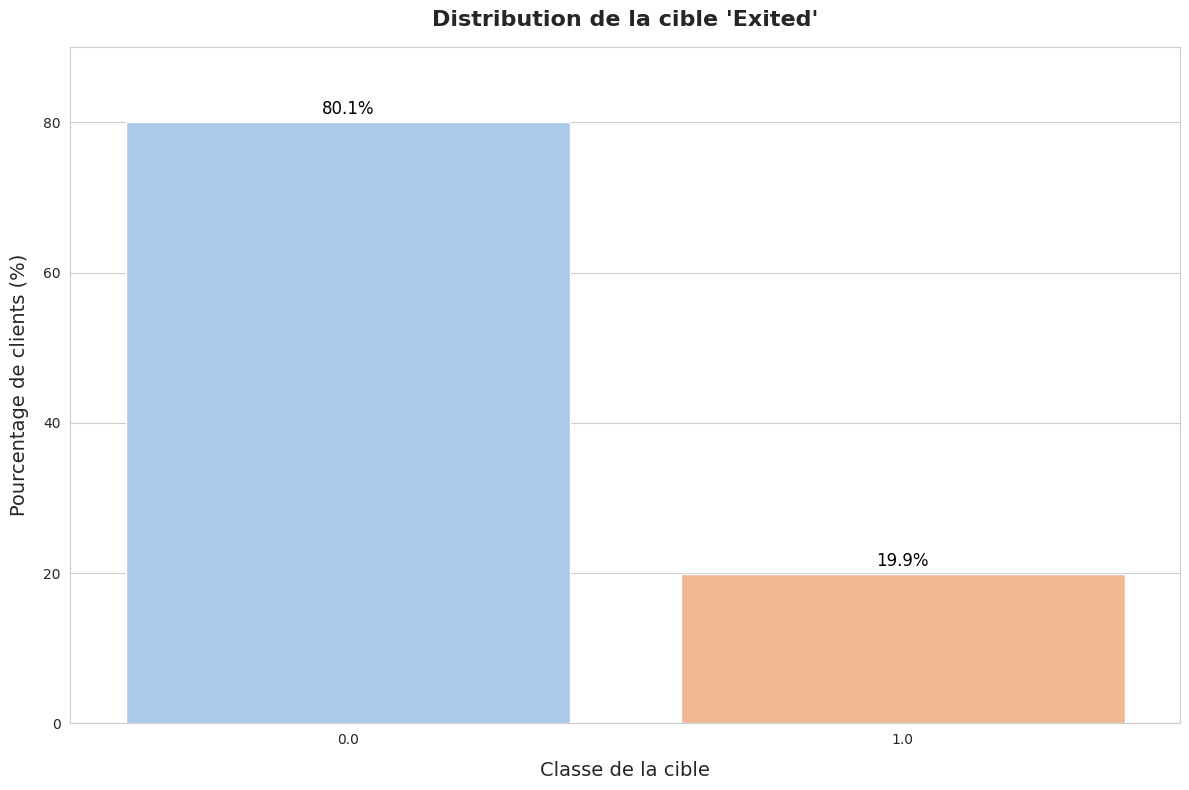

In [9]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

exited_train = train["Exited"].value_counts(normalize=True) * 100

# Graphique à barres avec Seaborn
sns.barplot(
    x=exited_train.index,
    y=exited_train.values,
    palette=sns.color_palette("pastel")
)

# Ajout des annotations pour afficher les pourcentages sur chaque barre
for i, v in enumerate(exited_train.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12, color='black')

plt.title("Distribution de la cible 'Exited'", fontsize=16, weight='bold', pad=15)
plt.xlabel('Classe de la cible', fontsize=14, labelpad=10)
plt.ylabel('Pourcentage de clients (%)', fontsize=14, labelpad=10)
plt.ylim(0, max(exited_train.values) + 10)

# Afficher le graphique
plt.tight_layout()
plt.show()


=> rééquilibrage des classes : SMOTE est fait ultérieurement



## Distribution des variables

### a) Distribution globale

#### a.1) Variables continues

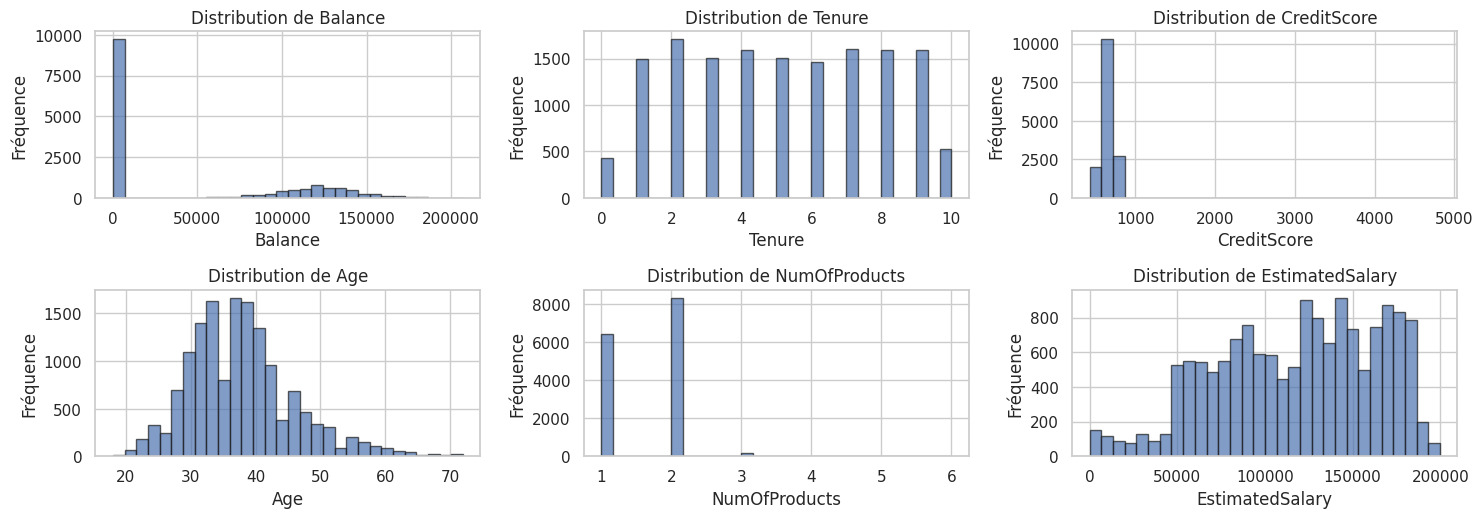

In [ ]:
# Distribution des variables numériques (sans la target)
plt.figure(figsize=(15, 10))
for i, column in enumerate(num_var, 1):
    plt.subplot(4, 3, i)  # 3 lignes, 2 colonnes
    plt.hist(train[column], bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution de {column}')
    plt.xlabel(column)
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

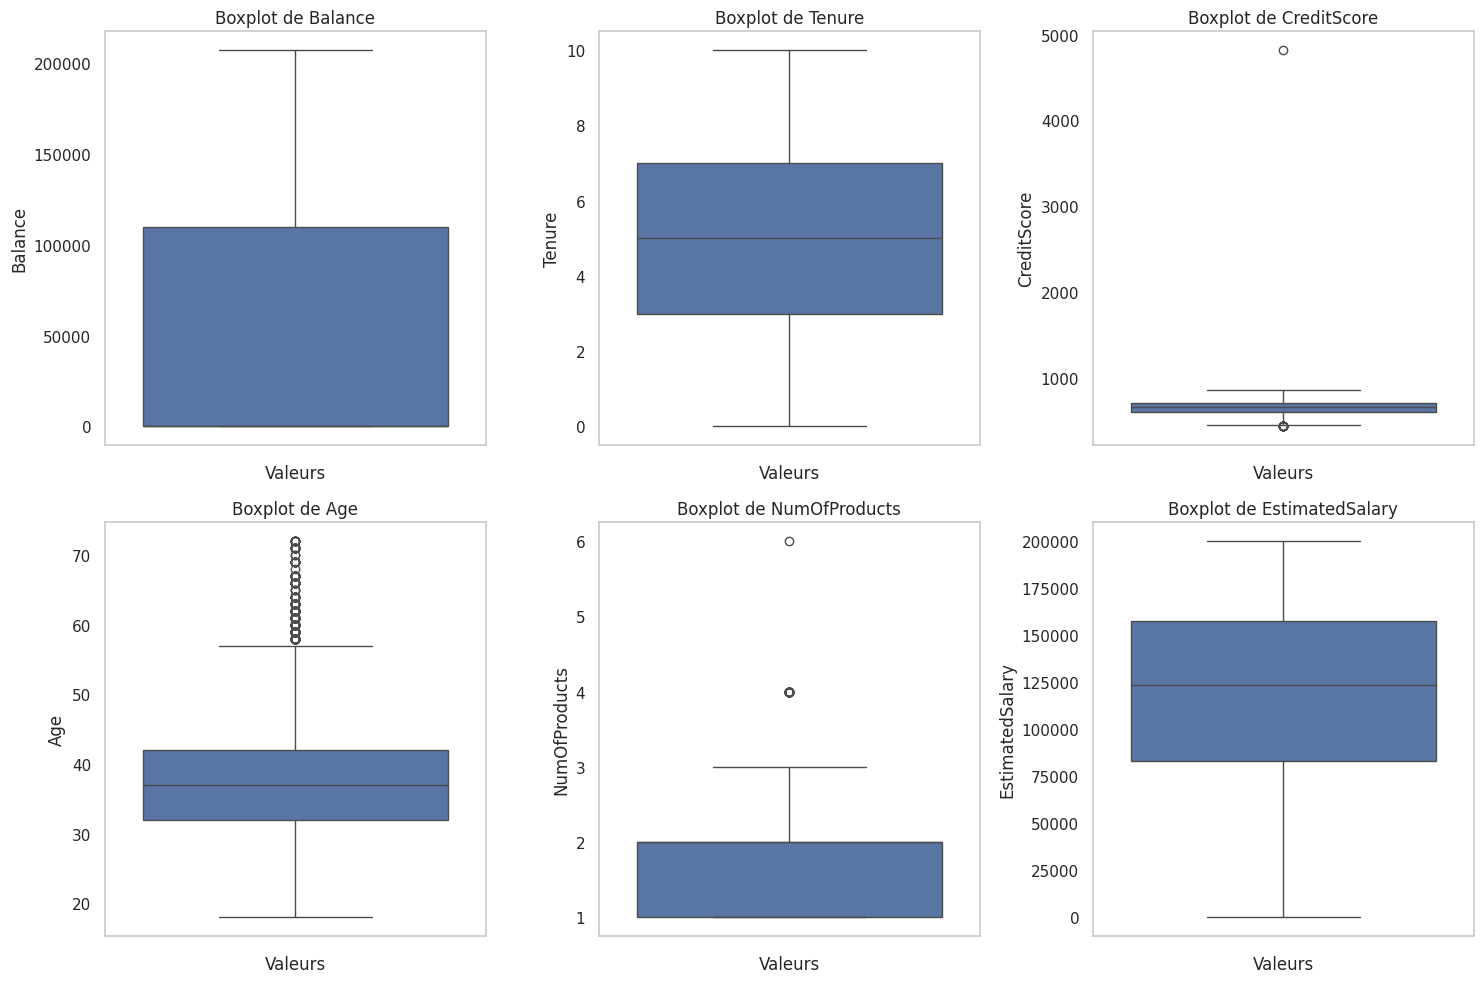

In [ ]:
# Boxplot des variables
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, column in zip(axes.flatten(), num_var):
    sns.boxplot(y=train[column], ax=ax)  # Utilisation de y pour un boxplot vertical
    ax.set_title(f"Boxplot de {column}")
    ax.set_xlabel("Valeurs")
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

#### a.2) Variables catégorielles

<ipython-input-19-6ba480df1e31>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x=column, palette='viridis')
<ipython-input-19-6ba480df1e31>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x=column, palette='viridis')
<ipython-input-19-6ba480df1e31>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x=column, palette='viridis')
<ipython-input-19-6ba480df1e31>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` an

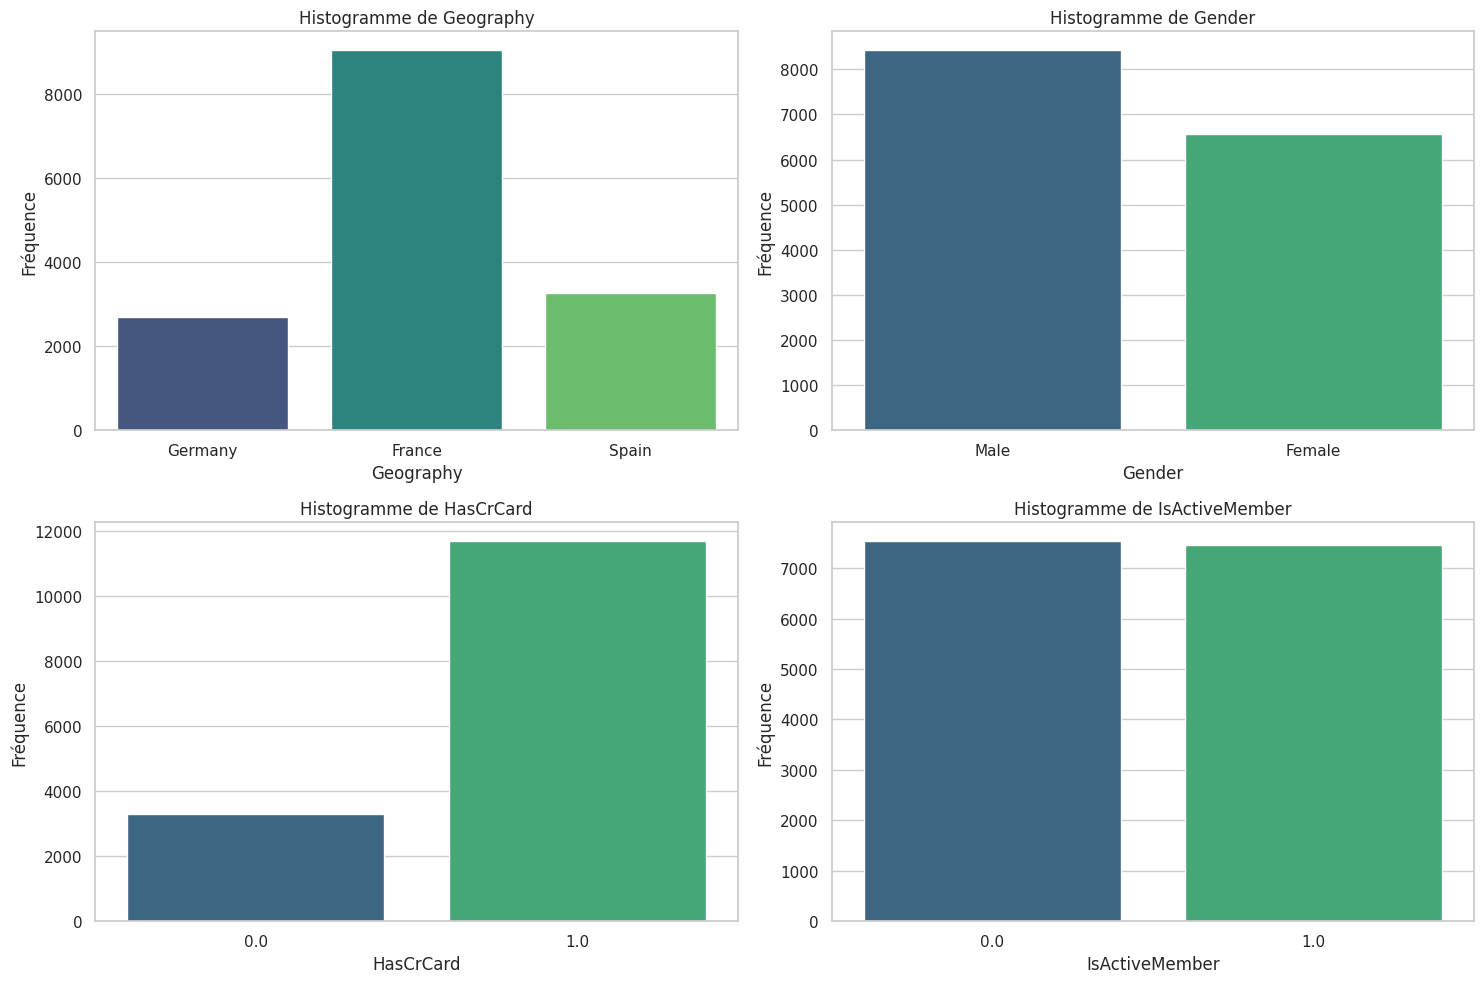

In [19]:
# Distribution des variables catégorielles
plt.figure(figsize=(15, 10))

for i, column in enumerate(cat_var, 1):
    plt.subplot(2, 2, i)  # 2 lignes, 2 colonnes
    sns.countplot(data=train, x=column, palette='viridis')
    plt.title(f'Histogramme de {column}')
    plt.xlabel(column)
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

### b) Distribution en fonction de la variable cible

#### b.1) Variables continues

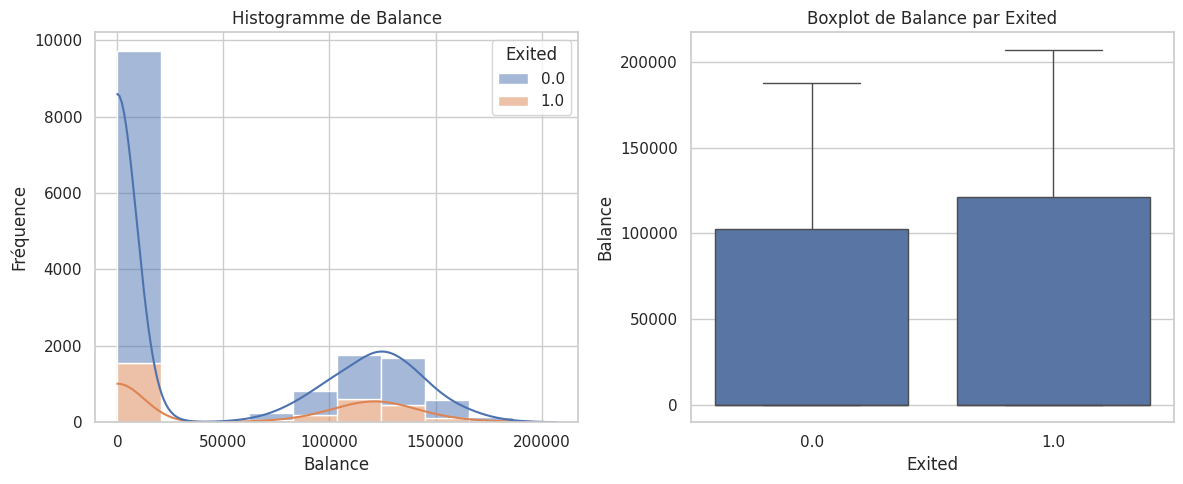

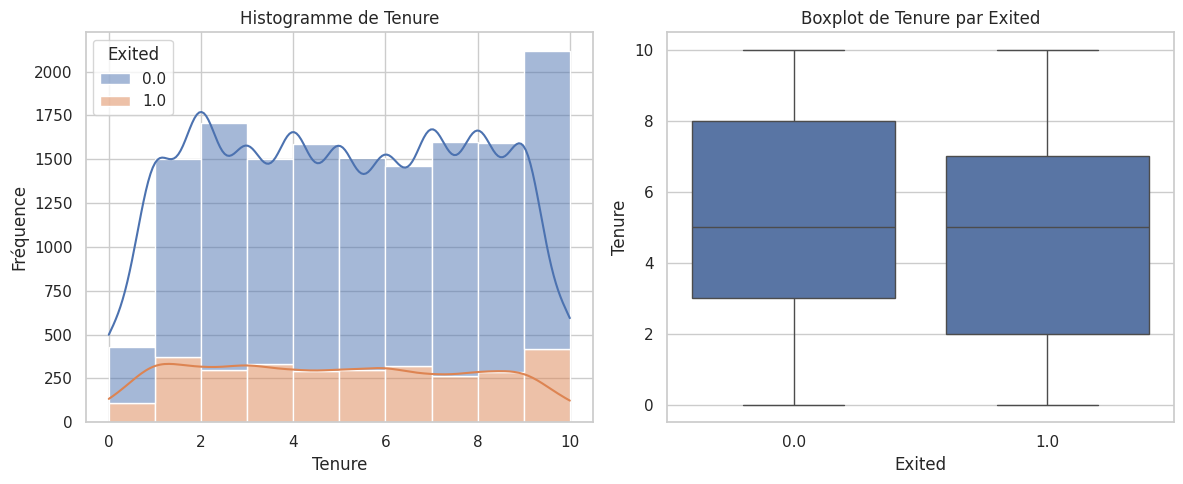

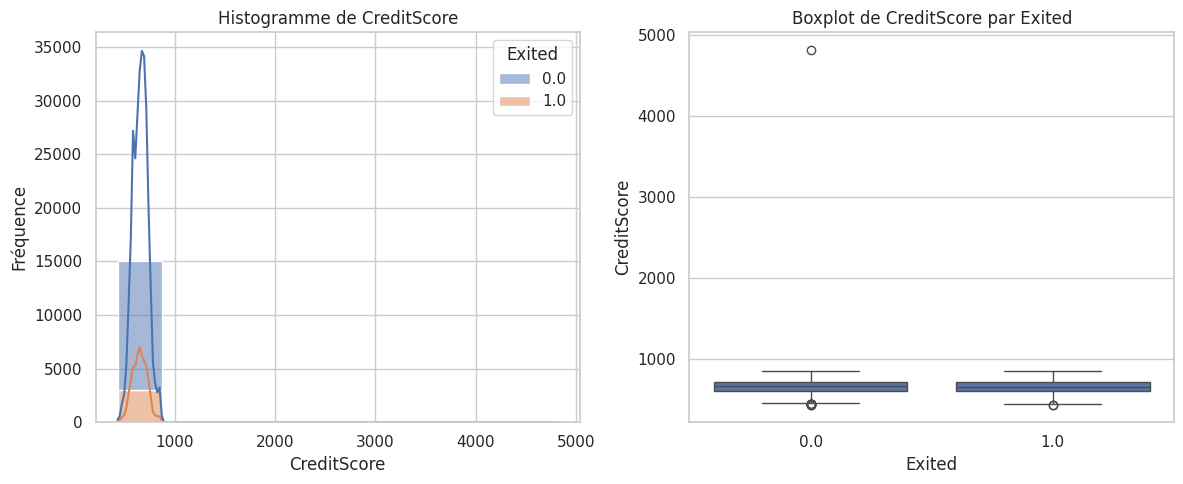

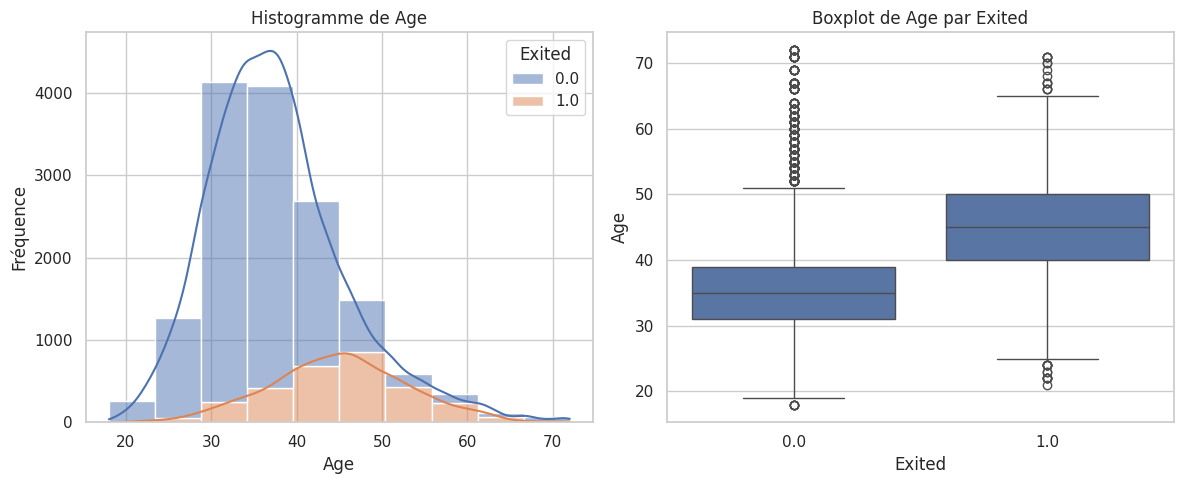

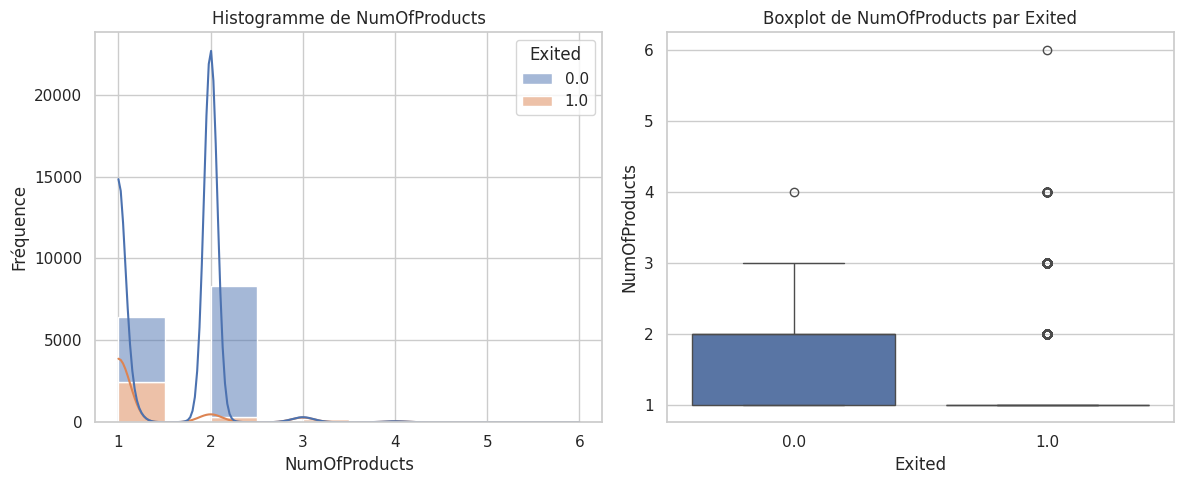

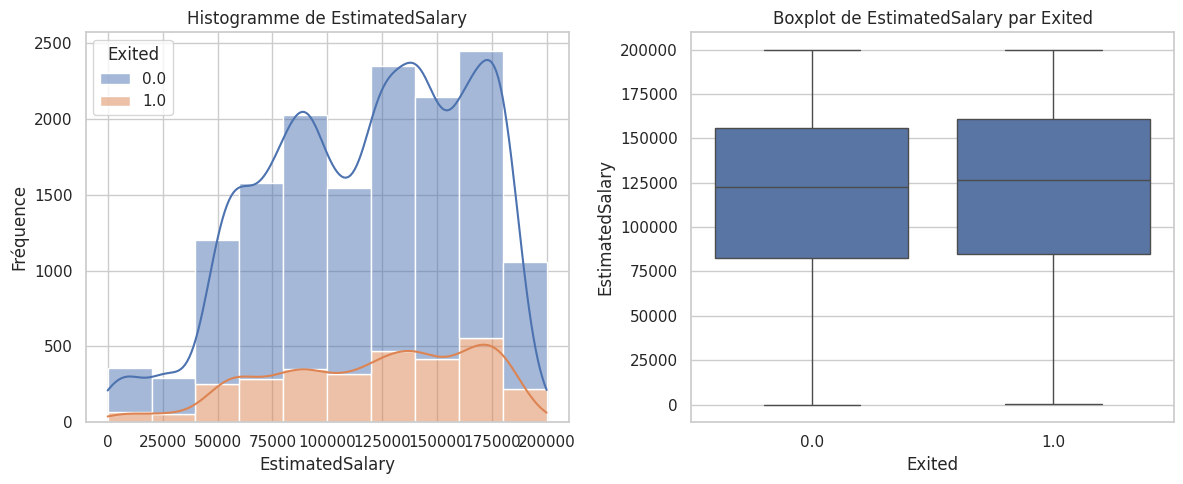

In [20]:
# Distribution des variables en fonction de la target
sns.set(style="whitegrid")

# Tracer un histogramme et un boxplot pour chaque variable numérique
for feature in num_var:
    plt.figure(figsize=(12, 5))

    # Histogramme
    plt.subplot(1, 2, 1)
    sns.histplot(train, x=feature, hue='Exited', multiple="stack", bins=10, kde=True)
    plt.title(f'Histogramme de {feature}')
    plt.xlabel(feature)
    plt.ylabel('Fréquence')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x='Exited', y=feature, data=train)
    plt.title(f'Boxplot de {feature} par Exited')
    plt.xlabel('Exited')
    plt.ylabel(feature)

    plt.tight_layout()
    plt.show()

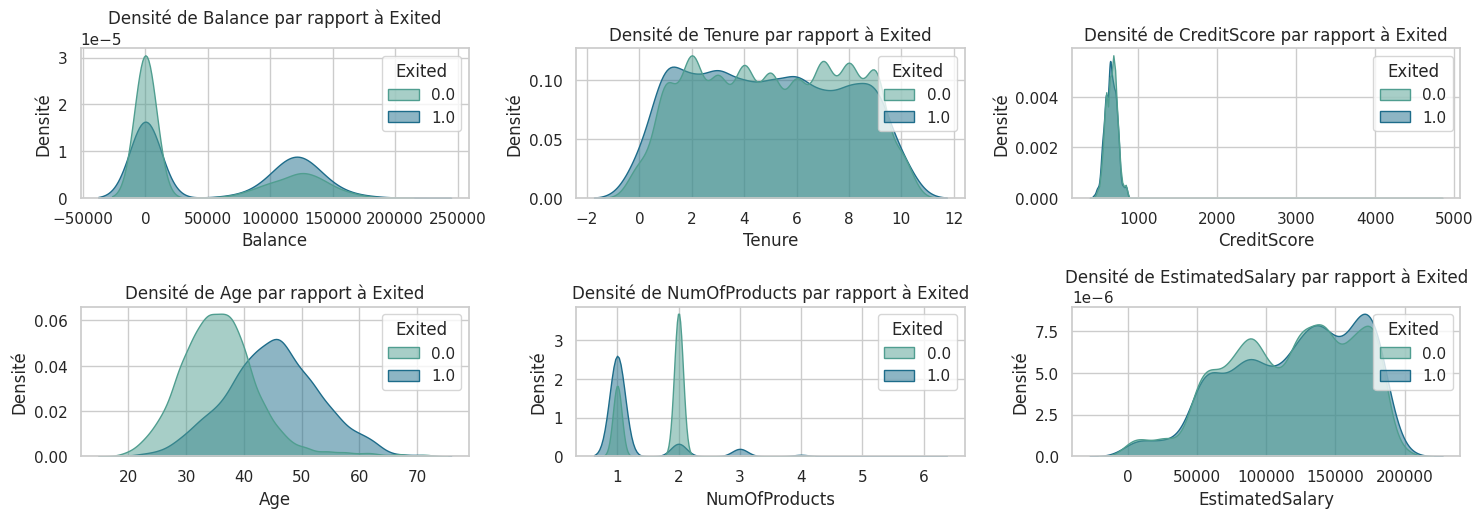

In [11]:
# Focus sur la densité des variables
plt.figure(figsize=(15, 10))

for i, column in enumerate(num_var, 1):
    plt.subplot(4, 3, i)
    sns.kdeplot(data=train, x=column, hue='Exited', common_norm=False, fill=True, palette='crest', alpha=0.5)
    plt.title(f'Densité de {column} par rapport à Exited')
    plt.xlabel(column)
    plt.ylabel('Densité')

plt.tight_layout()
plt.show()

#### b.2) Variables catégorielles

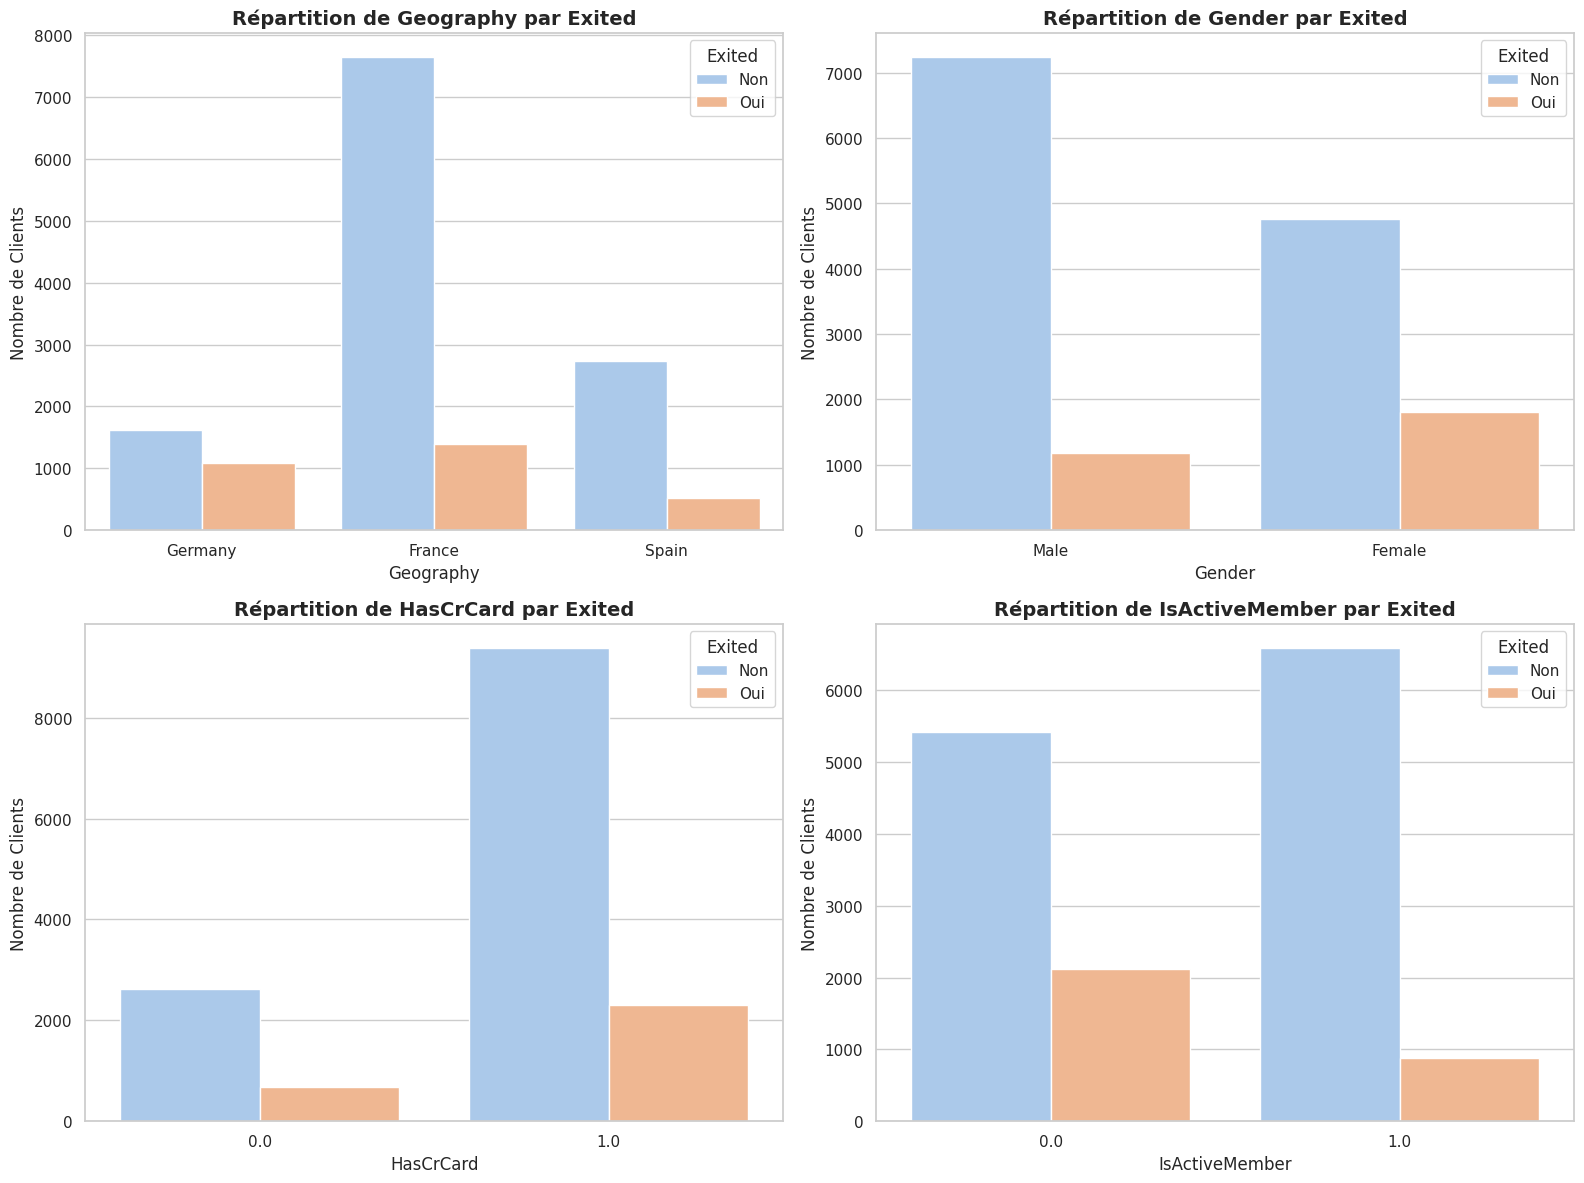

In [21]:
sns.set(style="whitegrid")

# Initialisation de la figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2x2 grille

# Tracer un barplot pour chaque variable catégorielle
for idx, feature in enumerate(cat_var):
    ax = axes[idx // 2, idx % 2]  # Accéder à la position correspondante dans la grille

    # Barplot pour la fréquence
    sns.countplot(
        x=feature,
        hue='Exited',
        data=train,
        palette='pastel',
        ax=ax
    )
    ax.set_title(f'Répartition de {feature} par Exited', fontsize=14, weight='bold')
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Nombre de Clients', fontsize=12)
    ax.legend(title='Exited', labels=['Non', 'Oui'])

# Ajustement des espaces
plt.tight_layout()
plt.show()


In [15]:
train=train.drop(columns=['id', 'CustomerId', 'Surname'], axis=1)
test=test.drop(columns=['CustomerId', 'Surname'], axis=1)

## Test de normalité (Shapiro-Wilk)

In [16]:
# Appliquer le test de Shapiro-Wilk sur toutes les colonnes numériques de train
for column in train.select_dtypes(include=['float64', 'int64']).columns:
    data = train[column]
    stat, p_value = shapiro(data)
    print(f"Test Shapiro-Wilk pour {column} : Stat={stat}, p-value={p_value}")

    if p_value > 0.05:
        print(f"{column}: Les données suivent une loi normale.")
    else:
        print(f"{column}: Les données ne suivent pas une loi normale.")


Test Shapiro-Wilk pour CreditScore : Stat=0.8424859412901599, p-value=1.696854955773744e-80
CreditScore: Les données ne suivent pas une loi normale.
Test Shapiro-Wilk pour Age : Stat=0.9634436469513012, p-value=3.030422247419062e-51
Age: Les données ne suivent pas une loi normale.
Test Shapiro-Wilk pour Tenure : Stat=0.9479102597820285, p-value=1.0238962566247314e-57
Tenure: Les données ne suivent pas une loi normale.
Test Shapiro-Wilk pour Balance : Stat=0.6805650441969152, p-value=4.3870206163397516e-97
Balance: Les données ne suivent pas une loi normale.
Test Shapiro-Wilk pour NumOfProducts : Stat=0.6805369770388705, p-value=4.365258140821211e-97
NumOfProducts: Les données ne suivent pas une loi normale.
Test Shapiro-Wilk pour HasCrCard : Stat=0.511101427459355, p-value=7.819867988596642e-108
HasCrCard: Les données ne suivent pas une loi normale.
Test Shapiro-Wilk pour IsActiveMember : Stat=0.6366184816499513, p-value=2.8010588753381947e-100
IsActiveMember: Les données ne suivent pa

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15000.
  res = hypotest_fun_out(*samples, **kwds)


# Preprocessing

### Détection des outliers

<ipython-input-33-ba0ade11db6b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train, y=column, ax=axes[row, col], palette="pastel", orient='v')  # Inversion en vertical
<ipython-input-33-ba0ade11db6b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train, y=column, ax=axes[row, col], palette="pastel", orient='v')  # Inversion en vertical
<ipython-input-33-ba0ade11db6b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train, y=column, ax=axes[row, col], palette="pastel", orient='v')  # Inversion en vertical
<ipython-input-3

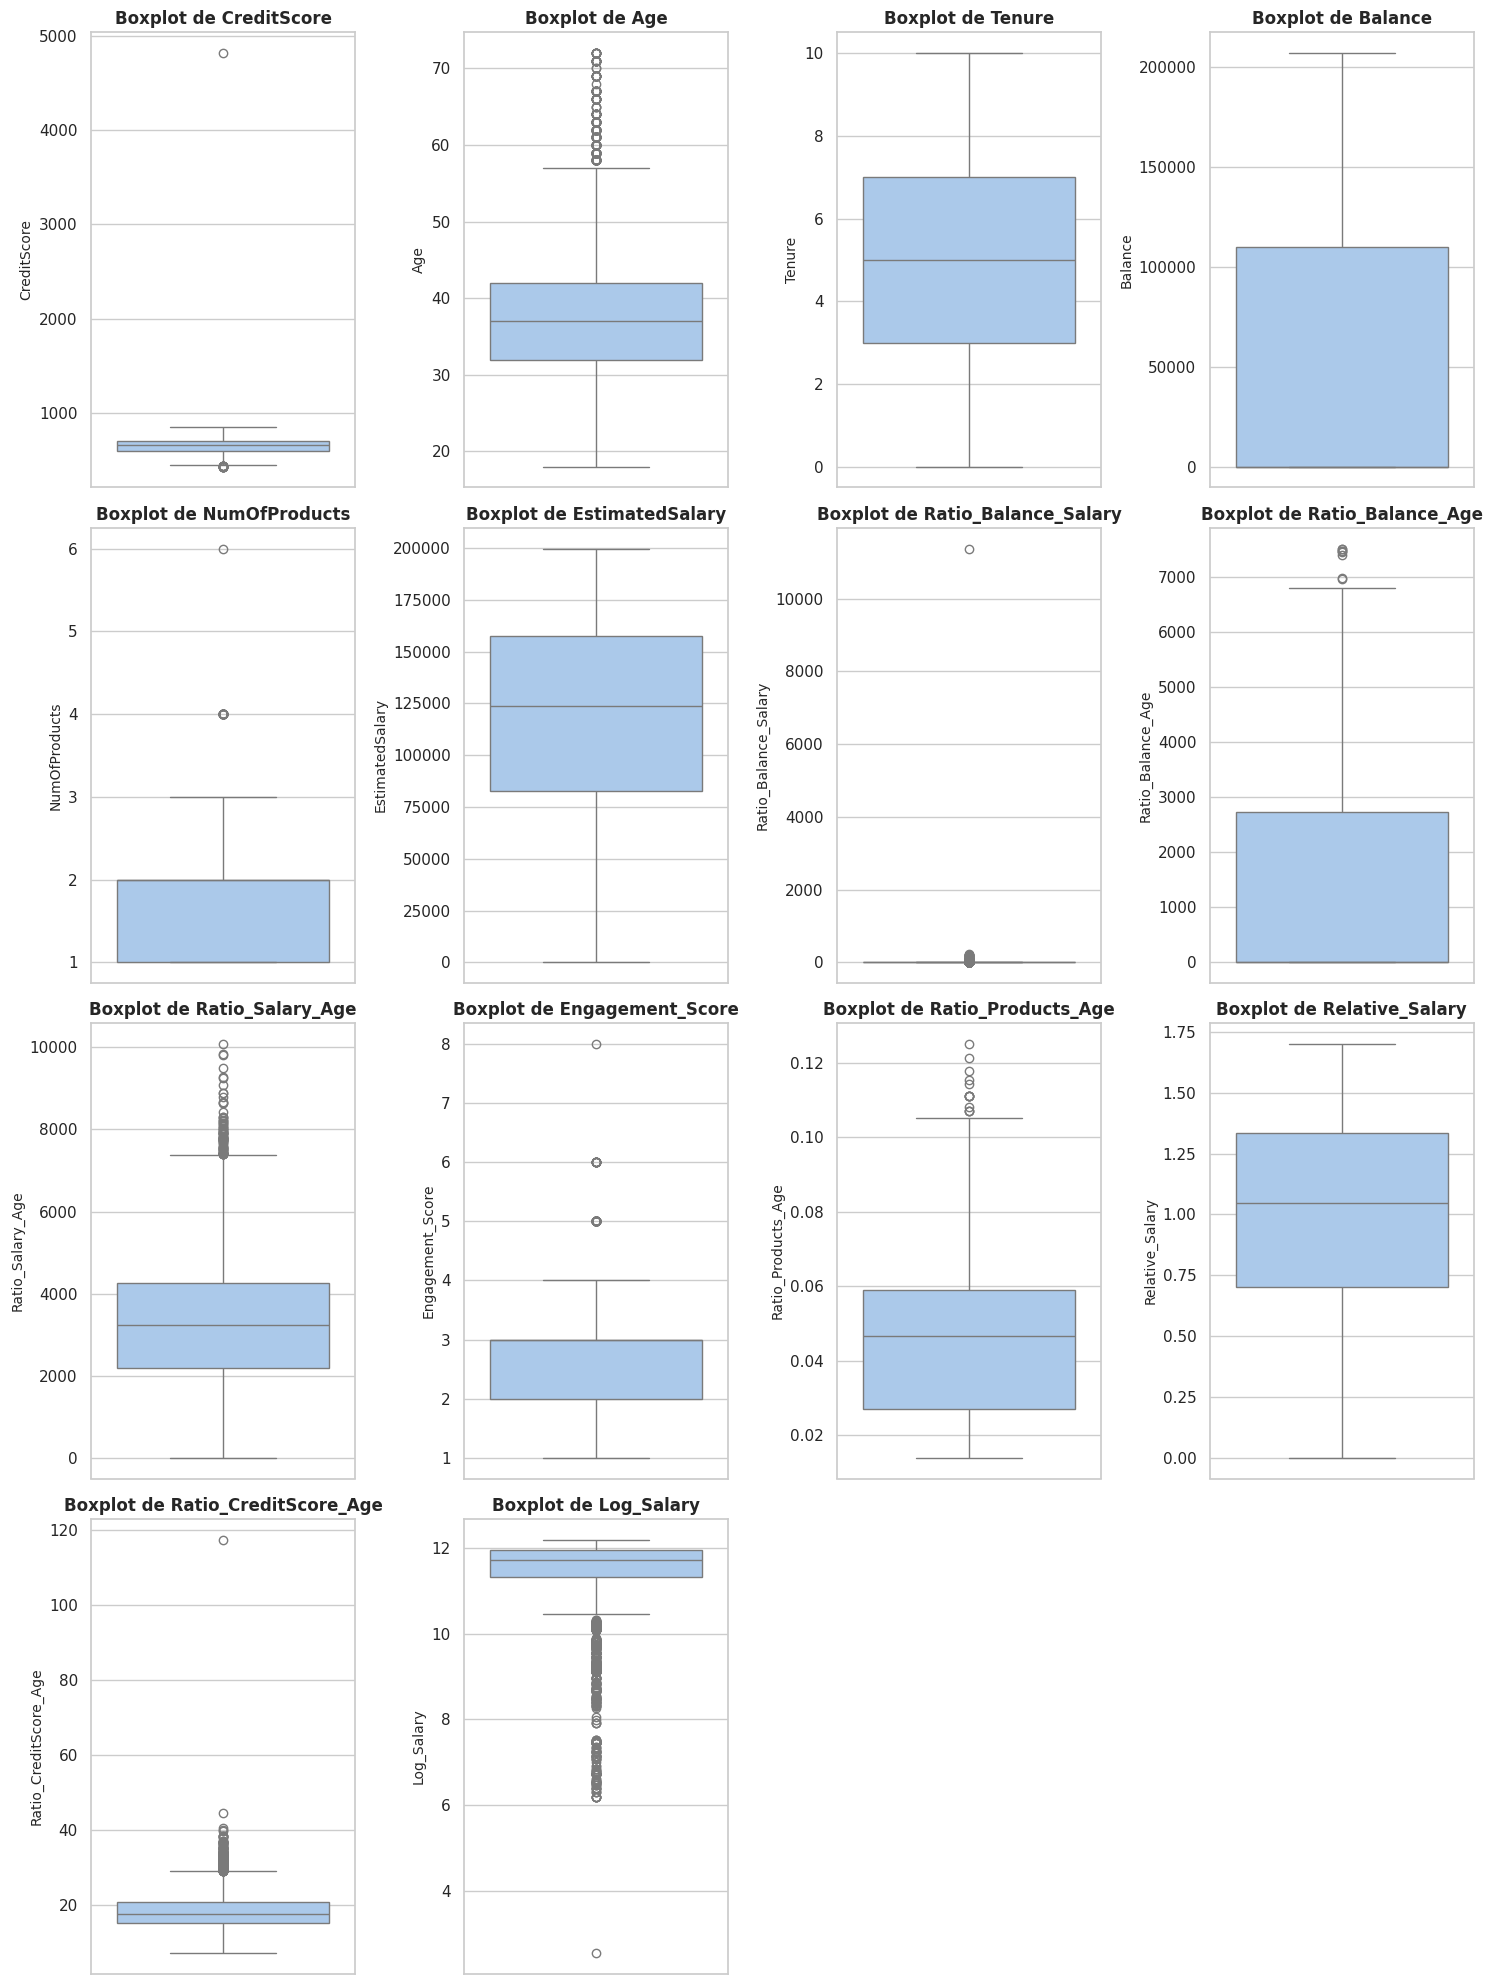

In [33]:
# Configuration des dimensions de la grille (4 lignes, 3 colonnes)
n_rows, n_cols = 4, 4  # Configuration pour un affichage vertical
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))

# Boucle pour tracer les boxplots
for i, column in enumerate(num_var):
    row, col = divmod(i, n_cols)
    sns.boxplot(data=train, y=column, ax=axes[row, col], palette="pastel", orient='v')  # Inversion en vertical
    axes[row, col].set_title(f"Boxplot de {column}", fontsize=12, weight="bold")
    axes[row, col].set_xlabel("")  # Pas d'étiquette pour les abscisses
    axes[row, col].set_ylabel(column, fontsize=10)

# Supprimer les axes inutilisés si le nombre de variables est inférieur à la grille
for j in range(len(num_var), n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()  # Optimise l'espacement
plt.show()


In [30]:
# Fonction pour supprimer les outliers en utilisant l'IQR
def remove_outliers(df, features):
    df_cleaned = df.copy()
    for feature in features:
        Q1 = df_cleaned[feature].quantile(0.25)
        Q3 = df_cleaned[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filtrer les lignes sans outliers
        df_cleaned = df_cleaned[(df_cleaned[feature] >= lower_bound) & (df_cleaned[feature] <= upper_bound)]
    return df_cleaned



## Feature Engineering

Nous avons formé des nouvelles variables dans le but de mieux comprendre, capturer et modéliser les comportements des clients en lien avec leur décision de churner.

**1. Ratio_Balance_Salary (Balance / EstimatedSalary):** représente la proportion du solde du compte par rapport au salaire estimé.
Les clients avec un ratio très faible (solde faible par rapport au salaire) pourraient être moins engagés dans les services de la banque, augmentant leur risque de churn.

**2. Ratio_Balance_Age (Balance / Age):** évalue la capacité d'un client à maintenir un solde en fonction de son âge.
Un ratio faible chez les clients plus âgés peut indiquer un désengagement ou une faible utilisation des services bancaires, ce qui est souvent associé au churn.

**3. Ratio_Salary_Age (EstimatedSalary / Age):** représente le salaire estimé ajusté à l’âge du client.
Les clients avec un faible salaire relatif à leur âge peuvent être financièrement instables ou moins attirés par des services premium, augmentant leur probabilité de churn.

**4. Engagement_Score (IsActiveMember + NumOfProducts + HasCrCard):** score global mesurant l’engagement du client à travers son activité, son nombre de produits et la possession d’une carte de crédit.
Un score élevé reflète un client fortement engagé avec la banque, donc moins susceptible de churner.

**5. Ratio_Products_Age (NumOfProducts / Age):** mesure du nombre de produits souscrits par an en fonction de l'âge du client.
Un ratio élevé pourrait indiquer un client plus actif ou investi, tandis qu’un ratio faible pourrait indiquer un désintérêt ou un faible engagement.

**6. Relative_Salary (EstimatedSalary / mean(EstimatedSalary) par pays):** compare le salaire estimé d’un client à la moyenne des salaires dans son pays.
Les clients avec un salaire inférieur à la moyenne locale peuvent être plus sensibles aux coûts et moins fidélisés, augmentant leur risque de churn.

**7. Ratio_CreditScore_Age (CreditScore / Age):** score de crédit ajusté à l’âge du client.
Un ratio faible peut indiquer un historique de crédit limité ou un risque financier accru, ce qui pourrait être associé au churn.

**8. Zero_Balance_HasCrCard (Balance == 0 & HasCrCard == 1):** identifie les clients ayant une carte de crédit mais aucun solde sur leur compte bancaire.
Ces clients peuvent être inactifs ou désengagés, ce qui est un indicateur fort de churn.

**9. Low_Balance_Active (Balance < mean(Balance) & IsActiveMember == 1):** indique les clients actifs avec un solde inférieur à la moyenne.
Un solde faible malgré un statut actif peut refléter une insatisfaction ou un faible usage, augmentant le risque de churn.

**10. Active_HasCrCard (IsActiveMember * HasCrCard):** reflète si un client est actif et possède une carte de crédit.
Ces clients utilisent des services critiques, ce qui pourrait indiquer un plus faible risque de churn.

**11. Log_Salary (np.log1p(EstimatedSalary)):** transformation logarithmique du salaire estimé pour réduire l’effet des valeurs extrêmes.
Elle permet de capturer une relation plus linéaire entre le salaire et le churn, surtout pour les clients ayant des salaires très élevés ou très faibles.

In [36]:
# 1. Ratio du solde par rapport au salaire estimé
train['Ratio_Balance_Salary'] = train['Balance'] / train['EstimatedSalary']

# 2. Ratio du solde par l'âge
train['Ratio_Balance_Age'] = train['Balance'] / train['Age']

# 3. Ratio du salaire par l'âge
train['Ratio_Salary_Age'] = train['EstimatedSalary'] / train['Age']

# 4. Score d'engagement
train['Engagement_Score'] = train['IsActiveMember'] + train['NumOfProducts'] + train['HasCrCard']

# 5. Ratio Produits/Age
train['Ratio_Products_Age'] = train['NumOfProducts'] / train['Age']

# 6. Score de revenu relatif par pays
train['Relative_Salary'] = train['EstimatedSalary'] / train.groupby('Geography')['EstimatedSalary'].transform('mean')

# 7. Ratio Crédit/Age
train['Ratio_CreditScore_Age'] = train['CreditScore'] / train['Age']

# 8. Solde nul avec une carte de crédit
train['Zero_Balance_HasCrCard'] = (train['Balance'] == 0) & (train['HasCrCard'] == 1)

# 9. Client actif avec faible solde
train['Low_Balance_Active'] = (train['Balance'] < train['Balance'].mean()) & (train['IsActiveMember'] == 1)

# 10. Possède une carte et est actif
train['Active_HasCrCard'] = train['IsActiveMember'] * train['HasCrCard']

# 11. Logarithme du salaire estimé
train['Log_Salary'] = np.log1p(train['EstimatedSalary'])

# 1. Ratio du solde par rapport au salaire estimé
test['Ratio_Balance_Salary'] = test['Balance'] / test['EstimatedSalary']

# 2. Ratio du solde par l'âge
test['Ratio_Balance_Age'] = test['Balance'] / test['Age']

# 3. Ratio du salaire par l'âge
test['Ratio_Salary_Age'] = test['EstimatedSalary'] / test['Age']

# 4. Score d'engagement
test['Engagement_Score'] = test['IsActiveMember'] + test['NumOfProducts'] + test['HasCrCard']

# 5. Ratio Produits/Age
test['Ratio_Products_Age'] = test['NumOfProducts'] / test['Age']

# 6. Score de revenu relatif par pays
test['Relative_Salary'] = test['EstimatedSalary'] / test.groupby('Geography')['EstimatedSalary'].transform('mean')

# 7. Ratio Crédit/Age
test['Ratio_CreditScore_Age'] = test['CreditScore'] / test['Age']

# 8. Solde nul avec une carte de crédit
test['Zero_Balance_HasCrCard'] = (test['Balance'] == 0) & (test['HasCrCard'] == 1)

# 9. Client actif avec faible solde
test['Low_Balance_Active'] = (test['Balance'] < test['Balance'].mean()) & (test['IsActiveMember'] == 1)

# 10. Possède une carte et est actif
test['Active_HasCrCard'] = test['IsActiveMember'] * test['HasCrCard']

# 11. Logarithme du salaire estimé
test['Log_Salary'] = np.log1p(test['EstimatedSalary'])

In [37]:
num_var=['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary','Ratio_Balance_Salary','Ratio_Balance_Age',
         'Ratio_Salary_Age','Engagement_Score','Ratio_Products_Age','Relative_Salary','Ratio_CreditScore_Age','Log_Salary']
cat_var=[ 'Geography','Gender','HasCrCard','IsActiveMember','Zero_Balance_HasCrCard','Low_Balance_Active','Active_HasCrCard']

## Transformation des données :

### Standardisation et Encodage

In [38]:
# Définir le préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_var),          # Standardisation des numériques
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_var)  # Encodage des catégoriques
    ]
)

### Validation croisée avancée

In [39]:
# Fonction pour mesurer la similarité des distributions
def measure_similarity(X_train, X_val):
    distances = []
    for col in X_train.columns:
        stat, _ = ks_2samp(X_train[col], X_val[col])  # KS-statistic
        distances.append(stat)
    return np.mean(distances)  # Moyenne des distances sur toutes les colonnes

# Création des splits avancés avec affichage des scores
def advanced_stratified_split(X, y, n_splits=5, max_similarity_threshold=0.1):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_splits = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        similarity_score = measure_similarity(X_train, X_val)

        print(f"Fold {fold + 1} :")
        print(f"  Taille train: {len(train_idx)}, Taille val: {len(val_idx)}")
        print(f"  Similarité moyenne (KS-statistic) : {similarity_score:.4f}")

        # Accepter seulement les splits avec une similarité élevée
        if similarity_score < max_similarity_threshold:
            best_splits.append((train_idx, val_idx))
        else:
            print(f"Similarité trop faible pour ce split (seuil = {max_similarity_threshold}).")

    if len(best_splits) < n_splits:
        print("Attention : Nombre insuffisant de splits satisfaisant les contraintes !")

    return best_splits

X = train.drop(columns=["Exited"])
y = train["Exited"]

# Générer les splits
splits = advanced_stratified_split(X, y, n_splits=5)


Fold 1 :
  Taille train: 12000, Taille val: 3000
  Similarité moyenne (KS-statistic) : 0.0107
Fold 2 :
  Taille train: 12000, Taille val: 3000
  Similarité moyenne (KS-statistic) : 0.0131
Fold 3 :
  Taille train: 12000, Taille val: 3000
  Similarité moyenne (KS-statistic) : 0.0099
Fold 4 :
  Taille train: 12000, Taille val: 3000
  Similarité moyenne (KS-statistic) : 0.0124
Fold 5 :
  Taille train: 12000, Taille val: 3000
  Similarité moyenne (KS-statistic) : 0.0132


# Modélisation avant sélections des variables

## Optimisation des modèles avec toutes les variables

In [ ]:
# Définir les modèles et leurs grilles d'hyperparamètres
models_and_params = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'n_estimators': [200, 400, 500, 600, 700],
            'max_depth': [3, 4, 5, 10, 15, 20, None],
            'min_samples_split': [5, 10, 13, 15, 17, 20],
            'min_samples_leaf': [4, 5, 6, 8, 10],
            'max_features': ['sqrt', 'log2', None],
            'random_state': list(range(101))
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(),
        'param_grid': {
            'penalty': ['l1', 'l2'],  # Inclure l1 et l2
            'C': [0.01, 0.1, 1, 10],  # Regularization strength
            'solver': ['liblinear', 'saga'],  # Résoudre le problème avec un solver compatible
            'max_iter': [1000, 2000, 3000, 4000],  # Nombre maximal d'itérations
            'random_state': list(range(0, 101))
        }
    },
    'SVM': {
        'model': SVC(probability=True),
        'param_grid': {
            'C': [0.09, 0.1 , 0.2 ,0.3 , 0.4, 0.5],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto'],
            'random_state': list(range(101))
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': [3, 5, 10, 20],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(),
        'param_grid': {
            'n_estimators': [100, 200, 500],
            'max_depth': [-1, 10, 20],
            'learning_rate': [0.01, 0.1, 0.2],
            'num_leaves': [31, 50, 100],
            'random_state': list(range(101))
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'param_grid': {
            'n_estimators': [100, 200, 500],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'random_state': list(range(101))
        }
    },
    # MLPClassifier
    'MLPClassifier': {
        'model': MLPClassifier(),
        'param_grid': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'activation': ['relu', 'tanh', 'logistic'],
            'solver': ['adam', 'sgd'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'max_iter': [200, 300, 400, 500],
            'random_state': list(range(0, 101))
        }
    },
    # AdaBoostClassifier
    'Adaboost': {
        'model': AdaBoostClassifier(),
        'param_grid': {
            'n_estimators': [50, 100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.5, 1, 2],
            'algorithm': ['SAMME'],
            'estimator': [DecisionTreeClassifier(max_depth=1)],
            'random_state': list(range(0, 101))
        }
    },
    # HistGradientBoostingClassifier
    'HistGradientBoostingClassifier': {
        'model': HistGradientBoostingClassifier(),
        'param_grid': {
            'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
            'max_iter': [100, 200, 300, 500, 1000],
            'max_depth': [3, 5, 7, 10, None],
            'max_leaf_nodes': [15, 31, 63, 127],
            'min_samples_leaf': [1, 5, 10, 20, 30, 50],
            'l2_regularization': [0, 0.01, 0.1, 1, 10],
            'loss': ['log_loss'],
            'scoring': [None],
            'random_state': list(range(0, 101, 10)),
            'early_stopping': [True, False],
            'validation_fraction': [0.1, 0.2, 0.3]
        }
    },
    # ExtraTreesClassifier
    'ExtraTreesClassifier': {
        'model': ExtraTreesClassifier(),
        'param_grid': {
            'n_estimators': [100, 200, 300, 500],
            'max_features': ['sqrt', 'log2', None],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False],
            'random_state': list(range(0, 101))
        }
    },
    # GaussianNB
    'GaussianNB': {
        'model': GaussianNB(),
        'param_grid': {
            'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
        }
    }
}

# Fonction d'optimisation
def optimize_single_model(model_name, config, X, y, splits, preprocessor):
    print(f"\nOptimisation pour le modèle : {model_name}")
    auc_scores = []

    def objective(trial):
        fold_scores = []
        for train_idx, val_idx in splits:
            # Séparer les données
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # Préparer les données
            X_train_transformed = preprocessor.fit_transform(X_train)
            X_val_transformed = preprocessor.transform(X_val)

            # Paramètres à optimiser
            params = {}
            for param_name, param_values in config['param_grid'].items():
                if param_name == 'random_state':
                    params[param_name] = trial.suggest_int(param_name, 0, 100)
                else:
                    params[param_name] = trial.suggest_categorical(param_name, param_values)

            # Créer et entraîner le modèle
            model = config['model'].set_params(**params)
            model.fit(X_train_transformed, y_train)

            # Prédictions et AUC
            y_pred = model.predict_proba(X_val_transformed)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            fold_scores.append(auc)

        return np.mean(fold_scores)

    # Étude Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30)

    # Résultats
    best_params = study.best_params
    mean_auc = study.best_value

    print(f"Meilleurs hyperparamètres pour {model_name} : {best_params}")
    print(f"AUC moyen pour {model_name} : {mean_auc:.4f}")
    return best_params, mean_auc

for model_name in models_and_params.keys():
    print(f"\n====== Optimisation du modèle {model_name} ======")
    config = models_and_params[model_name]
    best_params, mean_auc = optimize_single_model(model_name, config, X, y, splits, preprocessor)
    print(f"\nMeilleurs hyperparamètres pour {model_name} : {best_params}")
    print(f"AUC moyen pour {model_name} : {mean_auc:.4f}")


[I 2024-12-28 15:35:11,998] A new study created in memory with name: no-name-f3f48e73-8218-4002-b42c-433eff90a5db



====== Optimisation du modèle RandomForest ======

Optimisation pour le modèle : RandomForest


[I 2024-12-28 15:35:50,394] Trial 0 finished with value: 0.929797632407776 and parameters: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2', 'random_state': 48}. Best is trial 0 with value: 0.929797632407776.
[I 2024-12-28 15:36:09,568] Trial 1 finished with value: 0.9227634301404348 and parameters: {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'random_state': 35}. Best is trial 0 with value: 0.929797632407776.
[I 2024-12-28 15:37:18,160] Trial 2 finished with value: 0.9207363429026536 and parameters: {'n_estimators': 700, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': None, 'random_state': 13}. Best is trial 0 with value: 0.929797632407776.
[I 2024-12-28 15:39:40,463] Trial 3 finished with value: 0.9294638108154019 and parameters: {'n_estimators': 700, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_featu

Meilleurs hyperparamètres pour RandomForest : {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'log2', 'random_state': 79}
AUC moyen pour RandomForest : 0.9317

Meilleurs hyperparamètres pour RandomForest : {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'log2', 'random_state': 79}
AUC moyen pour RandomForest : 0.9317

====== Optimisation du modèle LogisticRegression ======

Optimisation pour le modèle : LogisticRegression


[I 2024-12-28 15:53:47,324] Trial 0 finished with value: 0.8795378850957535 and parameters: {'penalty': 'l1', 'C': 0.01, 'solver': 'saga', 'max_iter': 4000, 'random_state': 52}. Best is trial 0 with value: 0.8795378850957535.
[I 2024-12-28 15:53:47,735] Trial 1 finished with value: 0.8824360413145123 and parameters: {'penalty': 'l2', 'C': 0.1, 'solver': 'liblinear', 'max_iter': 4000, 'random_state': 60}. Best is trial 1 with value: 0.8824360413145123.
[I 2024-12-28 15:53:49,697] Trial 2 finished with value: 0.8795376066210154 and parameters: {'penalty': 'l1', 'C': 0.01, 'solver': 'saga', 'max_iter': 3000, 'random_state': 82}. Best is trial 1 with value: 0.8824360413145123.
[I 2024-12-28 15:53:51,617] Trial 3 finished with value: 0.8795377458583845 and parameters: {'penalty': 'l1', 'C': 0.01, 'solver': 'saga', 'max_iter': 2000, 'random_state': 79}. Best is trial 1 with value: 0.8824360413145123.
[I 2024-12-28 15:53:58,083] Trial 4 finished with value: 0.882317132601316 and parameters: {

Meilleurs hyperparamètres pour LogisticRegression : {'penalty': 'l1', 'C': 0.1, 'solver': 'liblinear', 'max_iter': 1000, 'random_state': 43}
AUC moyen pour LogisticRegression : 0.8825

Meilleurs hyperparamètres pour LogisticRegression : {'penalty': 'l1', 'C': 0.1, 'solver': 'liblinear', 'max_iter': 1000, 'random_state': 43}
AUC moyen pour LogisticRegression : 0.8825

====== Optimisation du modèle SVM ======

Optimisation pour le modèle : SVM


[I 2024-12-28 15:55:44,128] Trial 0 finished with value: 0.9045320371262522 and parameters: {'C': 0.1, 'kernel': 'poly', 'gamma': 'scale', 'random_state': 88}. Best is trial 0 with value: 0.9045320371262522.
[I 2024-12-28 15:57:02,755] Trial 1 finished with value: 0.9077077630402759 and parameters: {'C': 0.1, 'kernel': 'poly', 'gamma': 'auto', 'random_state': 35}. Best is trial 1 with value: 0.9077077630402759.
[I 2024-12-28 15:58:08,983] Trial 2 finished with value: 0.9109788665521208 and parameters: {'C': 0.3, 'kernel': 'poly', 'gamma': 'scale', 'random_state': 91}. Best is trial 2 with value: 0.9109788665521208.
[I 2024-12-28 15:59:20,136] Trial 3 finished with value: 0.9033086976014972 and parameters: {'C': 0.3, 'kernel': 'poly', 'gamma': 'auto', 'random_state': 12}. Best is trial 2 with value: 0.9109788665521208.
[I 2024-12-28 16:00:45,135] Trial 4 finished with value: 0.9177682199059312 and parameters: {'C': 0.3, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 8}. Best is trial

Meilleurs hyperparamètres pour SVM : {'C': 0.09, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 61}
AUC moyen pour SVM : 0.9233

Meilleurs hyperparamètres pour SVM : {'C': 0.09, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 61}
AUC moyen pour SVM : 0.9233

====== Optimisation du modèle KNN ======

Optimisation pour le modèle : KNN


[I 2024-12-28 16:36:34,252] Trial 0 finished with value: 0.9048307012829332 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.9048307012829332.
[I 2024-12-28 16:36:37,688] Trial 1 finished with value: 0.915289585880217 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 1 with value: 0.915289585880217.
[I 2024-12-28 16:36:40,777] Trial 2 finished with value: 0.8827480722586252 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.915289585880217.
[I 2024-12-28 16:36:42,580] Trial 3 finished with value: 0.8827480722586252 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.915289585880217.
[I 2024-12-28 16:36:46,147] Trial 4 finished with value: 0.8997745050807715 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with 

Meilleurs hyperparamètres pour KNN : {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'euclidean'}
AUC moyen pour KNN : 0.9153

Meilleurs hyperparamètres pour KNN : {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'euclidean'}
AUC moyen pour KNN : 0.9153

====== Optimisation du modèle LightGBM ======

Optimisation pour le modèle : LightGBM
[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:38:09,145] Trial 0 finished with value: 0.9276177321574274 and parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.2, 'num_leaves': 31, 'random_state': 99}. Best is trial 0 with value: 0.9276177321574274.


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:38:10,692] Trial 1 finished with value: 0.9237143517525809 and parameters: {'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.2, 'num_leaves': 50, 'random_state': 39}. Best is trial 0 with value: 0.9276177321574274.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:38:15,419] Trial 2 finished with value: 0.9161903820394933 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.2, 'num_leaves': 31, 'random_state': 3}. Best is trial 0 with value: 0.9276177321574274.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


[I 2024-12-28 16:38:16,699] Trial 3 finished with value: 0.9276177321574274 and parameters: {'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.2, 'num_leaves': 31, 'random_state': 33}. Best is trial 0 with value: 0.9276177321574274.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:38:23,244] Trial 4 finished with value: 0.9163797448614449 and parameters: {'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.2, 'num_leaves': 31, 'random_state': 28}. Best is trial 0 with value: 0.9276177321574274.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:38:25,477] Trial 5 finished with value: 0.9276619400221108 and parameters: {'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.01, 'num_leaves': 100, 'random_state': 14}. Best is trial 5 with value: 0.9276619400221108.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:38:27,655] Trial 6 finished with value: 0.9287273843703268 and parameters: {'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 55}. Best is trial 6 with value: 0.9287273843703268.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:38:31,757] Trial 7 finished with value: 0.9302464640670122 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'num_leaves': 100, 'random_state': 77}. Best is trial 7 with value: 0.9302464640670122.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:38:40,573] Trial 8 finished with value: 0.933436879523474 and parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 8}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:38:42,719] Trial 9 finished with value: 0.9287273843703268 and parameters: {'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 6}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:38:51,246] Trial 10 finished with value: 0.933436879523474 and parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 67}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:38:58,586] Trial 11 finished with value: 0.933436879523474 and parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 65}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:39:07,491] Trial 12 finished with value: 0.933436879523474 and parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 86}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:39:14,510] Trial 13 finished with value: 0.933436879523474 and parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 54}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:39:23,354] Trial 14 finished with value: 0.933436879523474 and parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 21}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:39:30,449] Trial 15 finished with value: 0.933436879523474 and parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 66}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:39:39,541] Trial 16 finished with value: 0.933436879523474 and parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 44}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:39:45,966] Trial 17 finished with value: 0.919459257753433 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'random_state': 77}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:39:58,075] Trial 18 finished with value: 0.9298339733611065 and parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 100, 'random_state': 64}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:40:01,165] Trial 19 finished with value: 0.9321978757946973 and parameters: {'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 98}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:40:09,495] Trial 20 finished with value: 0.919459257753433 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'num_leaves': 50, 'random_state': 19}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:40:16,543] Trial 21 finished with value: 0.933436879523474 and parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 66}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:40:25,258] Trial 22 finished with value: 0.933436879523474 and parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 47}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:40:32,967] Trial 23 finished with value: 0.933436879523474 and parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 79}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:40:41,111] Trial 24 finished with value: 0.933436879523474 and parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 58}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:40:53,135] Trial 25 finished with value: 0.9298339733611065 and parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 100, 'random_state': 89}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:41:00,198] Trial 26 finished with value: 0.933436879523474 and parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 71}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:41:09,169] Trial 27 finished with value: 0.933436879523474 and parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 38}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:41:10,816] Trial 28 finished with value: 0.9303731700728768 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 60}. Best is trial 8 with value: 0.933436879523474.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2024-12-28 16:41:14,866] Trial 29 finished with value: 0.921514122846346 and parameters: {'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 49}. Best is trial 8 with value: 0.933436879523474.
[I 2024-12-28 16:41:14,868] A new study created in memory with name: no-name-a738b648-e163-4209-aedf-7c7dbb6feb03
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:41:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Meilleurs hyperparamètres pour LightGBM : {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 8}
AUC moyen pour LightGBM : 0.9334

Meilleurs hyperparamètres pour LightGBM : {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'num_leaves': 50, 'random_state': 8}
AUC moyen pour LightGBM : 0.9334

====== Optimisation du modèle XGBoost ======

Optimisation pour le modèle : XGBoost


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:41:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:41:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:41:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:41:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-12-28 16:41:20,870] Trial 0 finished with value: 0.9278573596696175 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2, 

Meilleurs hyperparamètres pour XGBoost : {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 1.0, 'random_state': 75}
AUC moyen pour XGBoost : 0.9358

Meilleurs hyperparamètres pour XGBoost : {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 1.0, 'random_state': 75}
AUC moyen pour XGBoost : 0.9358

====== Optimisation du modèle MLPClassifier ======

Optimisation pour le modèle : MLPClassifier


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.


In [ ]:
# Définir les modèles et leurs grilles d'hyperparamètres
models_and_params = {
    'CatBoost': {
        'param_grid': {
            'iterations': [200, 300, 400, 500, 600],
            'depth': [5, 8, 10, 12],
            'learning_rate': [0.001, 0.01, 0.02, 0.03, 0.05],
            'l2_leaf_reg':  [10, 15, 20, 25, 30],
            'border_count': [32, 40, 50, 60],
            'random_state': list(range(101))
        }
    }
}

# Vérifiez les clés disponibles
print(models_and_params.keys())

# Fonction objective pour Optuna
def objective(trial):
    fold_scores = []
    for train_idx, val_idx in splits:
        # Séparer les données
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Préparer les données
        X_train_transformed = preprocessor.fit_transform(X_train)
        X_val_transformed = preprocessor.transform(X_val)

        # Paramètres à optimiser
        params = {
            'iterations': trial.suggest_categorical('iterations', [200, 300, 400, 500, 600]),
            'depth': trial.suggest_categorical('depth', [5, 8, 10, 12]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.02, 0.03, 0.05]),
            'l2_leaf_reg': trial.suggest_categorical('l2_leaf_reg', [10, 15, 20, 25, 30]),
            'border_count': trial.suggest_categorical('border_count', [32, 40, 50, 60]),
            'random_state': trial.suggest_int('random_state', 0, 100),
            'verbose': 0  # Désactiver les logs de CatBoost
        }

        # Créer un nouveau modèle CatBoost à chaque essai
        model = CatBoostClassifier(**params)

        # Entraîner le modèle
        model.fit(X_train_transformed, y_train)

        # Prédictions et calcul de l'AUC
        y_pred = model.predict_proba(X_val_transformed)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        fold_scores.append(auc)

    # Retourner la moyenne des scores AUC des folds
    return np.mean(fold_scores)

# Optimisation pour CatBoost
model_name = 'CatBoost'
config = models_and_params[model_name]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Résultats
best_params = study.best_params
mean_auc = study.best_value

print(f"\nMeilleurs hyperparamètres pour {model_name} : {best_params}")
print(f"AUC moyen pour {model_name} : {mean_auc:.4f}")


## Résultats des modèles optimisés sur les données d'entraînement

### 1. RandomForest
- **Meilleurs hyperparamètres** :
  - `n_estimators`: 700
  - `max_depth`: 10
  - `min_samples_split`: 13
  - `min_samples_leaf`: 5
  - `max_features`: 'log2'
  - `random_state`: 54
- **AUC moyen** : **0.9330**

---

### 2. LogisticRegression
- **Meilleurs hyperparamètres** :
  - `penalty`: 'l1'
  - `C`: 10
  - `solver`: 'liblinear'
  - `max_iter`: 3000
  - `random_state`: 76
- **AUC moyen** : **0.8915**

---

### 3. KNN
- **Meilleurs hyperparamètres** :
  - `n_neighbors`: 50
  - `weights`: 'distance'
  - `metric`: 'euclidean'
- **AUC moyen** : **0.9183**

---

### 4. LightGBM
- **Meilleurs hyperparamètres** :
  - `n_estimators`: 1000
  - `max_depth`: 5
  - `learning_rate`: 0.05
  - `num_leaves`: 150
  - `min_child_samples`: 100
  - `min_child_weight`: 0.01
  - `subsample`: 1.0
  - `colsample_bytree`: 0.8
  - `reg_alpha`: 10
  - `reg_lambda`: 10
  - `random_state`: 48
- **AUC moyen** : **0.9354**

---

### 5. XGBoost
- **Meilleurs hyperparamètres** :
  - `n_estimators`: 200
  - `max_depth`: 3
  - `learning_rate`: 0.05
  - `subsample`: 0.9
  - `colsample_bytree`: 0.9
  - `gamma`: 0
  - `min_child_weight`: 10
  - `reg_alpha`: 0.1
  - `reg_lambda`: 0.1
  - `scale_pos_weight`: 1
  - `random_state`: 54
- **AUC moyen** : **0.9367**

---

### 6. CatBoost
- **Meilleurs hyperparamètres** :
  - `iterations`: 400
  - `depth`: 5
  - `learning_rate`: 0.02
  - `l2_leaf_reg`: 25
  - `border_count`: 60
  - `random_state`: 53
- **AUC moyen** : **0.9372**

---

### 7. MLPClassifier
- **Meilleurs hyperparamètres** :
  - `hidden_layer_sizes`: (100,)
  - `activation`: 'logistic'
  - `solver`: 'adam'
  - `alpha`: 0.01
  - `learning_rate`: 'adaptive'
  - `max_iter`: 500
  - `random_state`: 47
- **AUC moyen** : **0.9356**

---

### 8. HistGradientBoostingClassifier
- **Meilleurs hyperparamètres** :
  - `learning_rate`: 0.1
  - `max_iter`: 200
  - `max_depth`: 3
  - `max_leaf_nodes`: 15
  - `min_samples_leaf`: 5
  - `l2_regularization`: 0.1
  - `loss`: 'log_loss'
  - `early_stopping`: True
  - `validation_fraction`: 0.2
  - `random_state`: 87
- **AUC moyen** : **0.9344**

---

### 9. ExtraTreesClassifier
- **Meilleurs hyperparamètres** :
  - `n_estimators`: 500
  - `max_features`: 'log2'
  - `max_depth`: 10
  - `min_samples_split`: 10
  - `min_samples_leaf`: 1
  - `bootstrap`: False
  - `random_state`: 51
- **AUC moyen** : **0.9340**

---

### 10. GaussianNB
- **Meilleurs hyperparamètres** :
  - `var_smoothing`: 1e-06
- **AUC moyen** : **0.8641**

---

### 11. Adaboost
- **Meilleurs hyperparamètres** :
  - `n_estimators`: 300
  - `learning_rate`: 1
  - `algorithm`: 'SAMME'
  - `estimator`: DecisionTreeClassifier(max_depth=1)
  - `random_state`: 43
- **AUC moyen** : **0.9304**



## Importances des variables par permutation

In [42]:
# Préparation des données pour l'entraînement
X_train_transformed = preprocessor.fit_transform(train)  # Appliquer le préprocesseur sur l'entraînement

# Récupérer les noms des colonnes après transformation
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
else:
    feature_names = train.columns

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

# Préparation des données de test
X_test_transformed = preprocessor.fit_transform(test)

if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
else:
    feature_names = test.columns

X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

Entraînement du modèle RandomForest...
Calcul des importances des variables pour RandomForest avec permutation...
Tracé des importances de variables pour RandomForest...


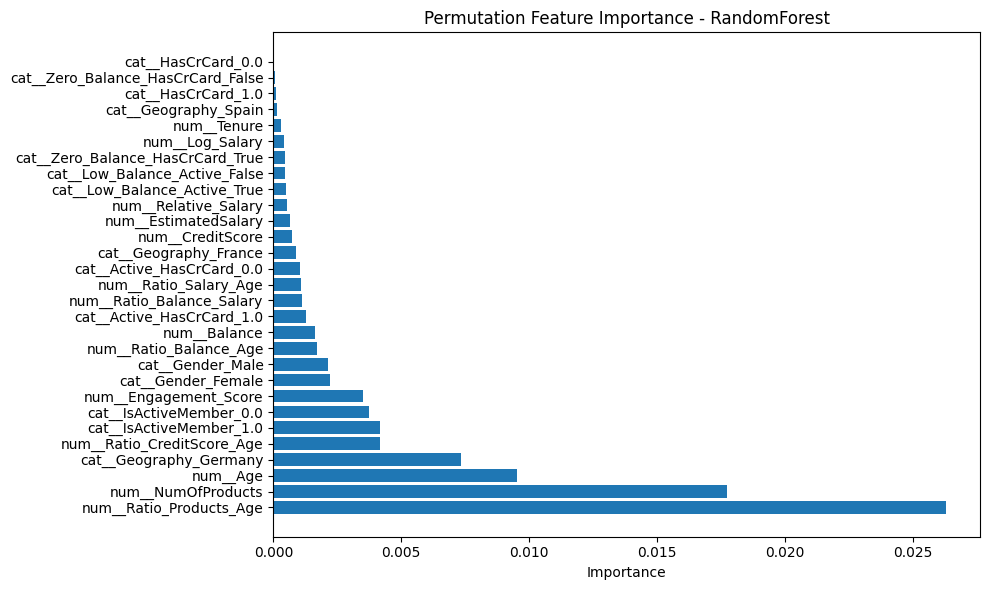

Entraînement du modèle LogisticRegression...
Calcul des importances des variables pour LogisticRegression avec permutation...
Tracé des importances de variables pour LogisticRegression...


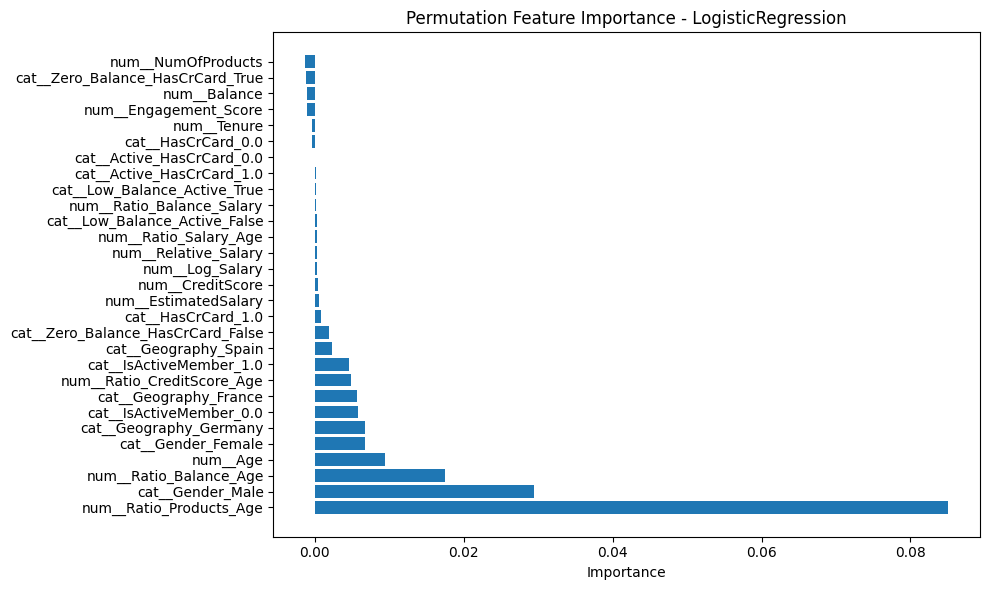

Entraînement du modèle KNN...
Calcul des importances des variables pour KNN avec permutation...
Tracé des importances de variables pour KNN...


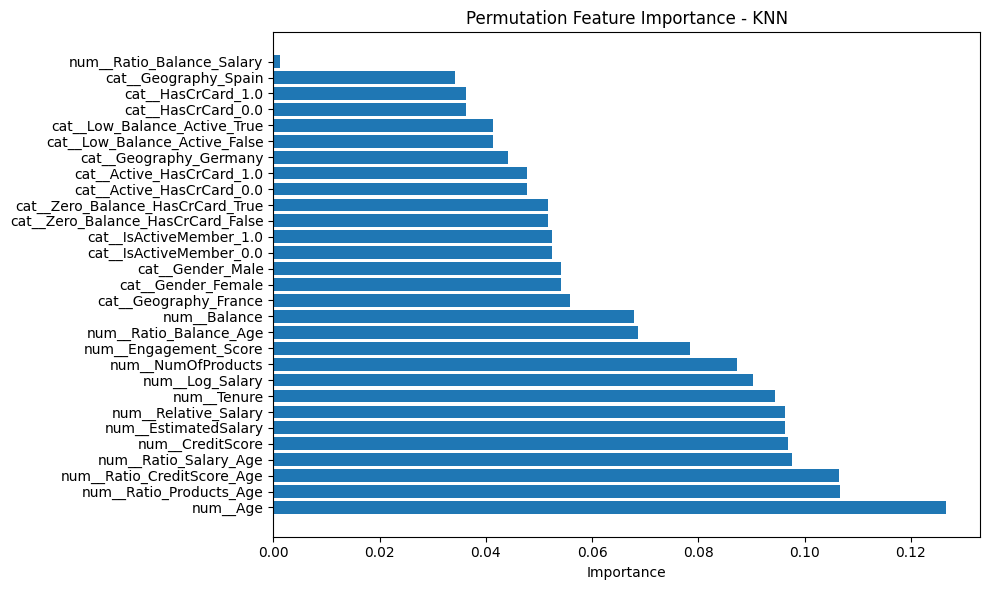

Entraînement du modèle LightGBM...
[LightGBM] [Info] Number of positive: 2990, number of negative: 12010
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2511
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

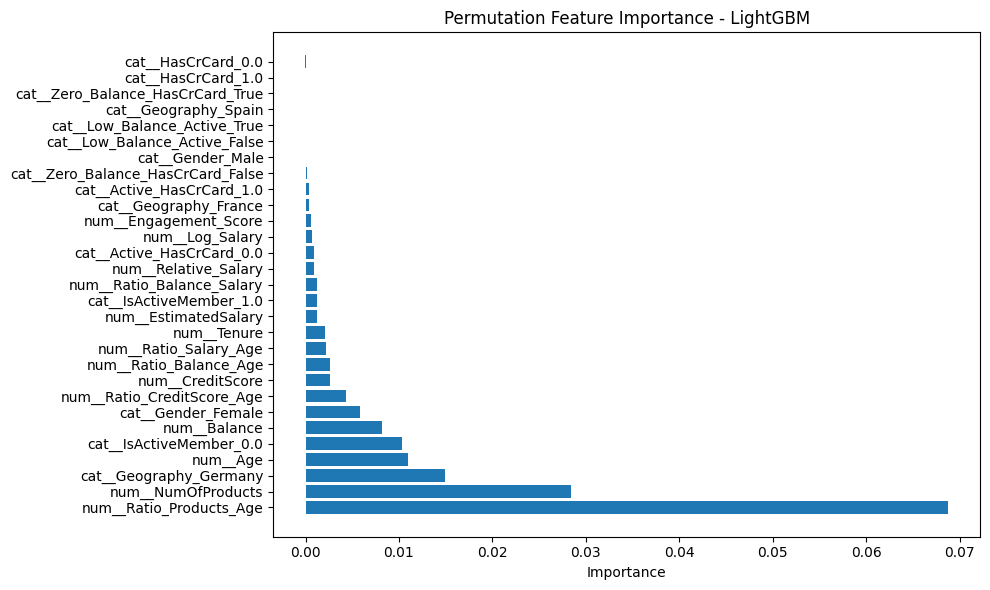

Entraînement du modèle XGBoost...
Calcul des importances des variables pour XGBoost avec permutation...
Tracé des importances de variables pour XGBoost...


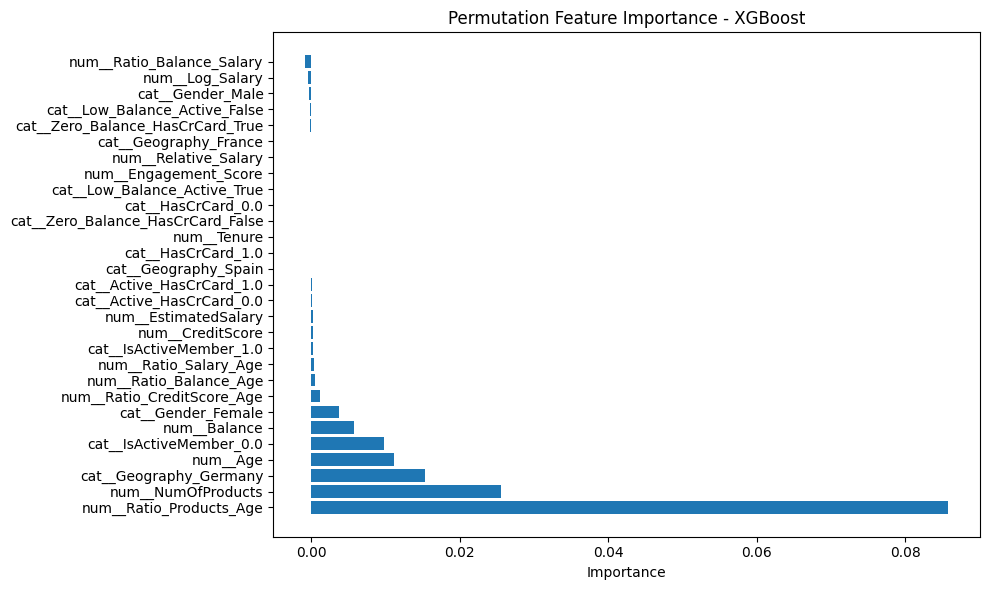

Entraînement du modèle CatBoost...
Calcul des importances des variables pour CatBoost avec permutation...
Tracé des importances de variables pour CatBoost...


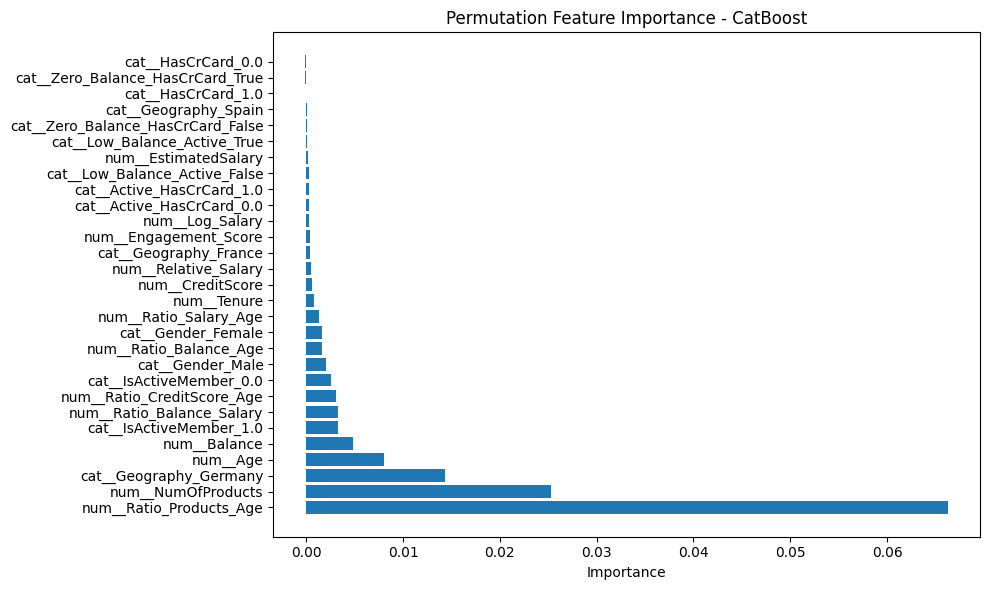

In [ ]:
# Liste des modèles et des hyperparamètres
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=300,  # Optimisé pour réduire le temps d'exécution
        max_depth=7,
        min_samples_split=13,
        min_samples_leaf=5,
        max_features='sqrt',
        random_state=54,
        n_jobs=-1  # Utilise tous les cœurs disponibles
    ),
    "LogisticRegression": LogisticRegression(
        penalty='l1', C=10, solver='liblinear', max_iter=3000, random_state=76
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=50, weights='distance', metric='euclidean'
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=1000, max_depth=5, learning_rate=0.05, num_leaves=150,
        min_child_samples=100, min_child_weight=0.01, subsample=1.0,
        colsample_bytree=0.8, reg_alpha=10, reg_lambda=10, random_state=48
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200, max_depth=3, learning_rate=0.05, subsample=0.9,
        colsample_bytree=0.9, gamma=0, min_child_weight=10,
        reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=1, random_state=54
    ),
    "CatBoost": CatBoostClassifier(
        iterations=600, depth=5, learning_rate=0.02,
        l2_leaf_reg=15, border_count=60, random_state=79, verbose=0
    ),
}

# Calcul des importances des variables via permutation pour chaque modèle
for model_name, model in models.items():
    print(f"Entraînement du modèle {model_name}...")
    model.fit(X_train_transformed_df, y)

    print(f"Calcul des importances des variables pour {model_name} avec permutation...")
    # Calcul des importances de permutation
    result = permutation_importance(model, X_train_transformed_df, y, n_repeats=30, random_state=42)

    # Récupérer les importances et les indices des variables
    importance_scores = result.importances_mean
    indices = importance_scores.argsort()[::-1]
    # Tracer les importances
    print(f"Tracé des importances de variables pour {model_name}...")
    plt.figure(figsize=(10, 6))
    plt.barh(range(X_train_transformed_df.shape[1]), importance_scores[indices], align="center")
    plt.yticks(range(X_train_transformed_df.shape[1]), X_train_transformed_df.columns[indices])
    plt.xlabel("Importance")
    plt.title(f"Permutation Feature Importance - {model_name}")
    plt.tight_layout()
    plt.show()


## Analyse des corrélations

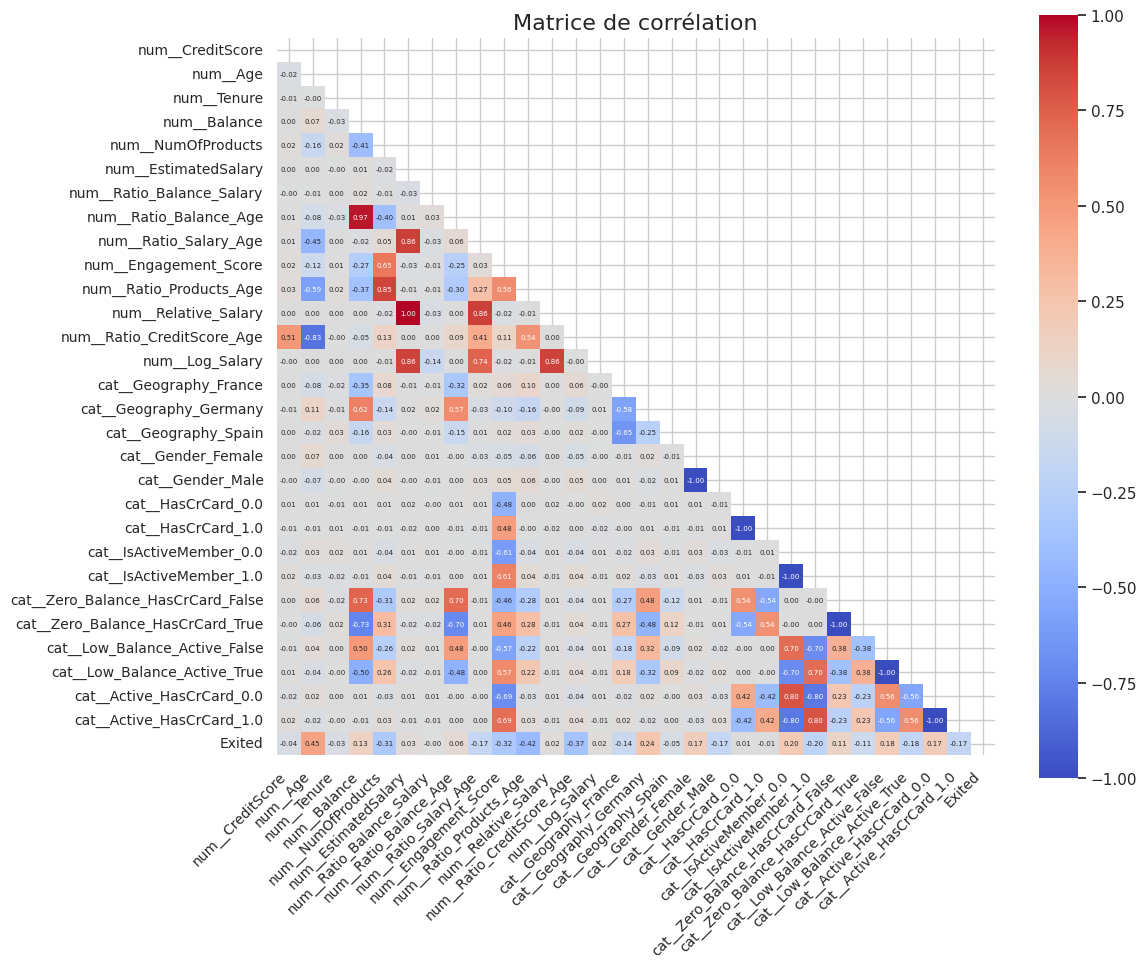

In [ ]:
# Transformation des données
train_transformed = preprocessor.fit_transform(train)
train_transformed = pd.DataFrame(train_transformed, columns=preprocessor.get_feature_names_out())
train_transformed['Exited'] = train['Exited']

# Calcul de la matrice de corrélation
correlation_matrix = train_transformed.corr()

# Masque pour la partie supérieure de la matrice
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Visualisation améliorée
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True,
    fmt=".2f",
    annot_kws={"size": 5}
)
plt.title('Matrice de corrélation', fontsize=16)
plt.xticks(fontsize=10, rotation=45, ha="right")
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


## Sélection des variables

### Analyse des variables importantes

### 1. Variables corrélées à la target
D'après la matrice de corrélation, les variables les plus corrélées à la target sont :
- **Age**
- **NumOfProducts**
- **Engagement_Score**
- **Ratio_Products_Age**
- **Ratio_CreditScore_Age**

---

### 2. Sélection des variables importantes
Nous avons décidé de conserver uniquement les variables dont l'importance est au moins **50 % de l'importance maximale**.  
Cette approche permet de :
- Réduire le nombre de variables.
- Maintenir celles qui ont une contribution significative.

---

### 3. Exemple : Résultats du modèle Random Forest
Selon le modèle Random Forest, les variables les plus importantes sont :
- **Ratio_Products_Age**
- **NumOfProducts**
- **Age**
- **Cat_Geography_Germany**

Cependant, comme **Ratio_Products_Age** et **NumOfProducts** sont fortement corrélées entre elles, nous avons décidé de :
- Supprimer **NumOfProducts** (la moins importante des deux).

In [40]:
selected_features_rf=["num__Ratio_Products_Age", "num__Age", "cat__Geography_Germany"]
selected_features_lr=["num__Ratio_Products_Age", "cat__IsActiveMember_1.0", "cat__Geography_Germany", "num__Ratio_Balance_Age"]
selected_features_knn=["num__Age", "num__Ratio_Products_Age", "num__CreditScore", "num__Ratio_Salary_Age", "num__Tenure", "num__NumOfProducts", "num__Engagement_Score", "num__Ratio_Balance_Age", "cat__Gender_Male", "cat__IsActiveMember_1.0", "cat__Geography_Germany"]
selected_features_lgbm=["num__Ratio_Products_Age", "num__Age","cat__Geography_Germany", "num__NumOfProducts", "cat__IsActiveMember_1.0"]
selected_features_xgb=["num__Ratio_Products_Age", "num__NumOfProducts", "cat__Geography_Germany","cat__IsActiveMember_1.0", "num__Age"]
selected_features_catb=["num__Ratio_Products_Age", "cat__Geography_Germany","num__Age", "cat__IsActiveMember_1.0"]
selected_features_mlp=["num__NumOfProducts", "num__Age","cat__Geography_Germany","cat__IsActiveMember_1.0"]
selected_features_hgb=["num__Ratio_Products_Age", "num__Age","cat__Geography_Germany","cat__IsActiveMember_1.0"]
selected_features_gnb=["cat__Low_Balance_Active_True", "cat__Active_HasCrCard_1.0", "num__NumOfProducts", "num__Age","cat__Geography_Germany"]
selected_features_etc=["num__Ratio_Products_Age", "num__Age", "cat__Geography_Germany","cat__IsActiveMember_1.0"]
selected_features_ada=["num__Ratio_Products_Age", "num__Balance", "cat__Geography_Germany","cat__IsActiveMember_1.0"]

# Modélisations sur les variables sélectionnées

In [ ]:
# # Définir les modèles et leurs grilles d'hyperparamètres
# models_and_params = {
#     'RandomForest': {
#         'model': RandomForestClassifier(),
#         'param_grid': {
#             'n_estimators': [200, 400, 500, 600],
#             'max_depth': [3, 4, 5, 10, 15],
#             'min_samples_split': [5, 10, 15, 20],
#             'min_samples_leaf': [4, 5, 6, 10],
#             'max_features': ['sqrt', 'log2'],
#             'random_state': list(range(101))
#         }
#     },
#     'LogisticRegression': {
#         'model': LogisticRegression(),
#         'param_grid': {
#             'penalty': ['l1', 'l2'],
#             'C': [0.1, 1, 10, 100],
#             'solver': ['liblinear', 'saga'],
#             'max_iter': [3000],
#             'random_state': list(range(101))
#         }
#     },
#     'KNN': {
#         'model': KNeighborsClassifier(),
#         'param_grid': {
#             'n_neighbors': [3, 5, 10, 20, 50],
#             'weights': ['uniform', 'distance'],
#             'metric': ['euclidean', 'manhattan']
#         }
#     },
#     'LightGBM': {
#         'model': LGBMClassifier(),
#         'param_grid': {
#             'n_estimators': [200, 500, 1000],
#             'max_depth': [3, 5, 10],
#             'learning_rate': [0.01, 0.05, 0.1],
#             'num_leaves': [15, 31, 63],
#             'min_child_samples': [10, 20, 50],
#             'random_state': list(range(101))
#         }
#     },
#     'XGBoost': {
#         'model': XGBClassifier(),
#         'param_grid': {
#             'n_estimators': [200, 500],
#             'max_depth': [3, 5, 10],
#             'learning_rate': [0.01, 0.05, 0.1],
#             'subsample': [0.8, 0.9, 1.0],
#             'colsample_bytree': [0.8, 0.9, 1.0],
#             'random_state': list(range(101))
#         }
#     },
#     'MLPClassifier': {
#         'model': MLPClassifier(),
#         'param_grid': {
#             'hidden_layer_sizes': [(50,), (100,), (150,)],
#             'activation': ['logistic', 'relu'],
#             'solver': ['adam', 'sgd'],
#             'alpha': [0.0001, 0.01, 0.1],
#             'learning_rate': ['constant', 'adaptive'],
#             'max_iter': [500],
#             'random_state': list(range(101))
#         }
#     },
#     'HistGradientBoostingClassifier': {
#         'model': HistGradientBoostingClassifier(),
#         'param_grid': {
#             'learning_rate': [0.01, 0.05, 0.1],
#             'max_iter': [100, 200],
#             'max_depth': [3, 5, 10],
#             'max_leaf_nodes': [15, 31, 63],
#             'min_samples_leaf': [5, 10, 20],
#             'l2_regularization': [0.1, 1, 10],
#             'random_state': list(range(101))
#         }
#     },
#     'ExtraTreesClassifier': {
#         'model': ExtraTreesClassifier(),
#         'param_grid': {
#             'n_estimators': [200, 400, 500],
#             'max_features': ['sqrt', 'log2'],
#             'max_depth': [5, 10, 15],
#             'min_samples_split': [5, 10],
#             'min_samples_leaf': [1, 2, 5],
#             'random_state': list(range(101))
#         }
#     },
#     'GaussianNB': {
#         'model': GaussianNB(),
#         'param_grid': {
#             'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
#         }
#     },
#     'AdaBoost': {
#         'model': AdaBoostClassifier(),
#         'param_grid': {
#             'n_estimators': [50, 100, 300],
#             'learning_rate': [0.01, 0.1, 1],
#             'algorithm': ['SAMME', 'SAMME.R'],
#             'random_state': list(range(101))
#         }
#     }
# }

# # Charger les données
# X = X_train_transformed_df[selected_features_rf] #Changer la sélection de features selon le modèle
# y = train["Exited"]

# # Générer les splits (validation croisée stratifiée)
# splits = advanced_stratified_split(X, y, n_splits=5)

# # Fonction d'optimisation avec SMOTE
# def optimize_with_smote(model_name, config, X, y, splits, n_trials=30):
#     print(f"\nOptimisation du modèle : {model_name}")

#     def objective(trial):
#         fold_scores = []
#         for train_idx, val_idx in splits:
#             X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#             y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#             smote = SMOTE(random_state=42)
#             X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#             params = {}
#             for param_name, param_values in config['param_grid'].items():
#                 if param_name == 'random_state':
#                     params[param_name] = trial.suggest_int(param_name, 0, 100)
#                 else:
#                     params[param_name] = trial.suggest_categorical(param_name, param_values)

#             model = config['model'].set_params(**params)
#             model.fit(X_train_smote, y_train_smote)
#             y_pred = model.predict_proba(X_val)[:, 1]
#             auc = roc_auc_score(y_val, y_pred)
#             fold_scores.append(auc)

#         return np.mean(fold_scores)

#     study = optuna.create_study(direction='maximize')
#     study.optimize(objective, n_trials=n_trials)

#     print(f"\nMeilleurs hyperparamètres pour {model_name} : {study.best_params}")
#     print(f"AUC moyen pour {model_name} : {study.best_value:.4f}")
#     return study.best_params, study.best_value

# # Lancer l'optimisation
# for model_name, config in models_and_params.items():
#     best_params, mean_auc = optimize_with_smote(model_name, config, X, y, splits)

## Modèle final

In [ ]:
#Modèle final avec différentes méthodes d'optimisation

# # Définir les modèles et leurs grilles d'hyperparamètres
# models_and_params = {
#     'CatBoost': {
#         'param_grid': {
#             'iterations': [200, 300, 400, 500, 600],
#             'depth': [5, 8, 10, 12],
#             'learning_rate': [0.001, 0.01, 0.02, 0.03, 0.05],
#             'l2_leaf_reg': [10, 15, 20, 25, 30],
#             'border_count': [32, 40, 50, 60],
#             'random_state': list(range(101))
#         }
#     }
# }

# # Charger les données
# X = X_train_transformed_df[selected_features_catb]
# y = train["Exited"]

# # Générer les splits (validation croisée stratifiée)
# splits = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Fonction pour SMOTE
# def apply_smote(X, y):
#     smote = SMOTE(random_state=42)
#     return smote.fit_resample(X, y)

# ### Bayesian Optimization ###
# def optimize_with_bayesian_search(X, y, param_grid, n_iter=30):
#     print("\nOptimisation avec Bayesian Search (Scikit-Optimize)")

#     # Définir l'espace de recherche
#     search_space = {
#         'iterations': Integer(min(param_grid['iterations']), max(param_grid['iterations'])),
#         'depth': Integer(min(param_grid['depth']), max(param_grid['depth'])),
#         'learning_rate': Real(min(param_grid['learning_rate']), max(param_grid['learning_rate']), prior='log-uniform'),
#         'l2_leaf_reg': Integer(min(param_grid['l2_leaf_reg']), max(param_grid['l2_leaf_reg'])),
#         'border_count': Integer(min(param_grid['border_count']), max(param_grid['border_count'])),
#         'random_state': Integer(0, 100),
#     }

#     # Configurer le modèle et la recherche bayésienne
#     model = CatBoostClassifier(verbose=0)
#     bayes_search = BayesSearchCV(
#         estimator=model,
#         search_spaces=search_space,
#         n_iter=n_iter,
#         cv=splits,
#         scoring='roc_auc',
#         random_state=42,
#         n_jobs=-1
#     )

#     # Appliquer SMOTE avant l'entraînement
#     X_smote, y_smote = apply_smote(X, y)
#     bayes_search.fit(X_smote, y_smote)

#     print("Meilleurs hyperparamètres Bayesian Optimization :", bayes_search.best_params_)
#     print("Meilleur score AUC Bayesian Optimization :", bayes_search.best_score_)
#     return bayes_search.best_params_

# # Lancer les optimisations
# for model_name, config in models_and_params.items():
#     param_grid = config['param_grid']

#     # Hyperopt
#     best_params_hyperopt = optimize_with_hyperopt(X, y, param_grid, max_evals=30)

#     # RandomizedSearchCV
#     best_params_random = optimize_with_random_search(X, y, param_grid, n_iter=30)

#     # GridSearchCV
#     best_params_grid = optimize_with_grid_search(X, y, param_grid)

#     # Bayesian Optimization
#     best_params_bayesian = optimize_with_bayesian_search(X, y, param_grid, n_iter=30)


In [ ]:
#Modèle final Catboost avec la méthode d'optimisation Optuna

# Définir les modèles et leurs grilles d'hyperparamètres
models_and_params = {
    'CatBoost': {
        'param_grid': {
            'iterations': [200, 300, 400, 500, 600],
            'depth': [5, 8, 10, 12],
            'learning_rate': [0.001, 0.01, 0.02, 0.03, 0.05],
            'l2_leaf_reg': [10, 15, 20, 25, 30],
            'border_count': [32, 40, 50, 60],
            'random_state': list(range(101))  # Ajout du random_state
        }
    }
}

# Charger les données
X = X_train_transformed_df[selected_features_catb]
y = train["Exited"]

# Générer les splits (validation croisée stratifiée)
splits = advanced_stratified_split(X, y, n_splits=5)

# Fonction d'optimisation avec SMOTE
def optimize_single_model_with_smote(model_name, config, X, y, splits):
    print(f"\nOptimisation pour le modèle : {model_name}")

    def objective(trial):
        fold_scores = []
        for train_idx, val_idx in splits:
            # Séparer les données en train et validation
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # Appliquer SMOTE sur l'ensemble d'entraînement
            smote = SMOTE(random_state=42)
            X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

            # Paramètres à optimiser
            params = {
                'iterations': trial.suggest_categorical('iterations', config['param_grid']['iterations']),
                'depth': trial.suggest_categorical('depth', config['param_grid']['depth']),
                'learning_rate': trial.suggest_categorical('learning_rate', config['param_grid']['learning_rate']),
                'l2_leaf_reg': trial.suggest_categorical('l2_leaf_reg', config['param_grid']['l2_leaf_reg']),
                'border_count': trial.suggest_categorical('border_count', config['param_grid']['border_count']),
                'random_state': trial.suggest_int('random_state', 0, 100)
            }

            # Créer une nouvelle instance du modèle avec les paramètres optimisés
            model = CatBoostClassifier(**params, verbose=0)
            model.fit(X_train_smote, y_train_smote)

            # Prédictions et AUC
            y_pred = model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            fold_scores.append(auc)

        return np.mean(fold_scores)

    # Étude Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30)

    # Résultats
    best_params = study.best_params
    mean_auc = study.best_value

    return best_params, mean_auc

for model_name in models_and_params.keys():
    print(f"\n====== Optimisation du modèle {model_name} avec SMOTE ======")
    config = models_and_params[model_name]
    best_params, mean_auc = optimize_single_model_with_smote(model_name, config, X, y, splits)
    print(f"\nMeilleurs hyperparamètres pour {model_name} : {best_params}")
    print(f"AUC moyen pour {model_name} : {mean_auc:.4f}")


[I 2024-12-25 23:47:34,722] A new study created in memory with name: no-name-0a300d7e-7aa9-4e7f-aeb1-2c020b696d79


dict_keys(['CatBoost'])


[I 2024-12-25 23:49:04,401] Trial 0 finished with value: 0.9320050320385187 and parameters: {'iterations': 600, 'depth': 12, 'learning_rate': 0.001, 'l2_leaf_reg': 25, 'border_count': 32, 'random_state': 98}. Best is trial 0 with value: 0.9320050320385187.
[I 2024-12-25 23:49:16,048] Trial 1 finished with value: 0.936689464465231 and parameters: {'iterations': 200, 'depth': 8, 'learning_rate': 0.03, 'l2_leaf_reg': 20, 'border_count': 50, 'random_state': 25}. Best is trial 1 with value: 0.936689464465231.
[I 2024-12-25 23:49:42,145] Trial 2 finished with value: 0.9333289705624355 and parameters: {'iterations': 200, 'depth': 10, 'learning_rate': 0.05, 'l2_leaf_reg': 10, 'border_count': 50, 'random_state': 66}. Best is trial 1 with value: 0.936689464465231.
[I 2024-12-25 23:51:39,642] Trial 3 finished with value: 0.9326983645178627 and parameters: {'iterations': 300, 'depth': 12, 'learning_rate': 0.02, 'l2_leaf_reg': 10, 'border_count': 50, 'random_state': 79}. Best is trial 1 with value:


Meilleurs hyperparamètres pour CatBoost : {'iterations': 400, 'depth': 5, 'learning_rate': 0.02, 'l2_leaf_reg': 25, 'border_count': 60, 'random_state': 53}
AUC moyen pour CatBoost : 0.9372


## Réentrainement du modèle final avec les features sélectionnées

In [ ]:
# Entraîner le modèle CatBoost avec les meilleurs hyperparamètres
model = CatBoostClassifier(
    iterations=400,
    depth=5,
    learning_rate=0.02,
    l2_leaf_reg=25,
    border_count=60,
    random_state=53,
    verbose=0  # Désactiver les logs pendant l'entraînement
)

# Entraîner le modèle avec les données transformées
model.fit(X_train_transformed_df[selected_features_catb], y)

# Prédire les classes et les probabilités sur l'ensemble de test
y_pred_proba = model.predict_proba(X_test_transformed_df[selected_features_catb])[:, 1]

# Créer un DataFrame avec les prédictions et l'ID
results = pd.DataFrame({
    "id": test["id"],  # Colonne d'identifiant
    "Exited": y_pred_proba  # Probabilités de la classe positive
})

# Sauvegarder les résultats dans un fichier CSV
results.to_csv("predictions.csv", index=False)

print("Les prédictions ont été sauvegardées dans 'predictions.csv'.")


Les prédictions ont été sauvegardées dans 'predictions.csv'.


# Comparaison des résultats

## Comparaison des performances avant et après le retrait des outliers

In [ ]:
def measure_similarity(X_train, X_val):
    from scipy.stats import ks_2samp
    similarities = []
    for col in X_train.columns:
        if X_train[col].dtype in ['int64', 'float64']:
            similarities.append(ks_2samp(X_train[col], X_val[col]).statistic)
    return np.mean(similarities) if similarities else 0.0

def advanced_stratified_split(X, y, n_splits=5, max_similarity_threshold=0.1):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    splits = list(skf.split(X, y))
    return splits

def compute_scores(models, X_train, y_train, X_val, y_val):
    scores = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        scores[model_name] = roc_auc_score(y_val, y_pred)
    return scores

def compute_scores_with_advanced_split(models, X, y, preprocessor, n_splits=5):
    splits = advanced_stratified_split(X, y, n_splits)
    all_scores = []

    for fold, (train_idx, val_idx) in enumerate(splits):
        print(f"\nProcessing Fold {fold + 1}")

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_train_transformed = pd.DataFrame(
            preprocessor.fit_transform(X_train),
            columns=(
                num_var +
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_var))
            )
        )

        X_val_transformed = pd.DataFrame(
            preprocessor.transform(X_val),
            columns=X_train_transformed.columns
        )

        fold_scores = compute_scores(models, X_train_transformed, y_train, X_val_transformed, y_val)
        print(f"Scores for Fold {fold + 1}: {fold_scores}")
        all_scores.append(fold_scores)

    avg_scores = {model: np.mean([scores[model] for scores in all_scores]) for model in models.keys()}
    return avg_scores

# Définition des modèles
models = {
    "RandomForest": RandomForestClassifier(n_estimators=700, max_depth=10, min_samples_split=13, min_samples_leaf=5, max_features='log2', random_state=54),
    "LogisticRegression": LogisticRegression(penalty='l1', C=10, solver='liblinear', max_iter=3000, random_state=76),
    "KNN": KNeighborsClassifier(n_neighbors=50, weights='distance', metric='euclidean'),
    "LightGBM": LGBMClassifier(n_estimators=1000, max_depth=5, learning_rate=0.05, num_leaves=150, min_child_samples=100, min_child_weight=0.01, subsample=1.0, colsample_bytree=0.8, reg_alpha=10, reg_lambda=10, random_state=48),
    "XGBoost": XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, gamma=0, min_child_weight=10, reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=1, random_state=54, use_label_encoder=False, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(iterations=400, depth=5, learning_rate=0.02, l2_leaf_reg=25, border_count=60, random_state=53, verbose=0),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', solver='adam', alpha=0.01, learning_rate='adaptive', max_iter=500, random_state=47),
    "HistGradientBoosting": HistGradientBoostingClassifier(learning_rate=0.1, max_iter=200, max_depth=3, max_leaf_nodes=15, min_samples_leaf=5, l2_regularization=0.1, loss='log_loss', random_state=87),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=500, max_features='log2', max_depth=10, min_samples_split=10, min_samples_leaf=1, bootstrap=False, random_state=51),
    "GaussianNB": GaussianNB(var_smoothing=1e-06),
    "AdaBoost": AdaBoostClassifier(n_estimators=300, learning_rate=1, algorithm='SAMME', random_state=43)
}

# Définir le préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_var),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_var)
    ]
)

# 1. Sans retrait des outliers
print("\nEvaluation sans retrait des outliers :")
scores_no_outliers = compute_scores_with_advanced_split(models, X, y, preprocessor)

# 2. Avec retrait des outliers
print("\nEvaluation avec retrait des outliers :")
# Prétraitement initial
X_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X),
    columns=(
        num_var +
        list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_var))
    )
)

# Détection des outliers
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(X_preprocessed)

# Filtrer les données
X_no_outliers = X[outliers == 1]
y_no_outliers = y[outliers == 1]

scores_after_outliers = compute_scores_with_advanced_split(models, X_no_outliers, y_no_outliers, preprocessor)


# Création de la matrice de scores
score_matrix = pd.DataFrame({
    "Sans retrait des outliers": scores_no_outliers,
    "Avec retrait des outliers": scores_after_outliers
}).T

print("\nMatrice finale des scores :")
print(score_matrix)




Evaluation sans retrait des outliers :

Processing Fold 1
[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:57:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Scores for Fold 1: {'RandomForest': 0.9365098482591151, 'LogisticRegression': 0.8823214489597577, 'KNN': 0.9254168070643471, 'LightGBM': 0.9393349744777904, 'XGBoost': 0.9399486631820196, 'CatBoost': 0.9397429399692008, 'MLPClassifier': 0.9383902489285684, 'HistGradientBoosting': 0.9383805023127327, 'ExtraTrees': 0.9345103996390968, 'GaussianNB': 0.8754814132036013, 'AdaBoost': 0.9334434932985055}

Processing Fold 2
[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:58:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Scores for Fold 2: {'RandomForest': 0.9414541672352194, 'LogisticRegression': 0.8964714465927223, 'KNN': 0.9280741522532784, 'LightGBM': 0.9443043561803292, 'XGBoost': 0.9445915332540611, 'CatBoost': 0.944996365904667, 'MLPClassifier': 0.9436986736248222, 'HistGradientBoosting': 0.9440457227672592, 'ExtraTrees': 0.9423007304392381, 'GaussianNB': 0.8806847136861979, 'AdaBoost': 0.935081620945756}

Processing Fold 3
[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No fur

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:59:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Scores for Fold 3: {'RandomForest': 0.9308693424376008, 'LogisticRegression': 0.8826590995797816, 'KNN': 0.9203666676877408, 'LightGBM': 0.9329126508288801, 'XGBoost': 0.9336749754246044, 'CatBoost': 0.9341462939189472, 'MLPClassifier': 0.933555231287194, 'HistGradientBoosting': 0.9335701993043701, 'ExtraTrees': 0.9304474532092822, 'GaussianNB': 0.8841621669790225, 'AdaBoost': 0.9313904382913905}

Processing Fold 4
[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 844
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:59:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Scores for Fold 4: {'RandomForest': 0.9270500614036798, 'LogisticRegression': 0.8807793950971737, 'KNN': 0.9186154096781111, 'LightGBM': 0.9306208037337894, 'XGBoost': 0.9330637233743342, 'CatBoost': 0.9325986705616001, 'MLPClassifier': 0.9294421594045096, 'HistGradientBoosting': 0.9322888674153924, 'ExtraTrees': 0.9258616704585644, 'GaussianNB': 0.8654451836401662, 'AdaBoost': 0.9244167346609153}

Processing Fold 5
[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 844
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:00:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Scores for Fold 5: {'RandomForest': 0.9318732438686824, 'LogisticRegression': 0.8693584498982175, 'KNN': 0.9199788916148472, 'LightGBM': 0.933820478475295, 'XGBoost': 0.9338657306202468, 'CatBoost': 0.9346489408213333, 'MLPClassifier': 0.9285935076399544, 'HistGradientBoosting': 0.9334257405339474, 'ExtraTrees': 0.9259570480563855, 'GaussianNB': 0.8622392432170516, 'AdaBoost': 0.9276038780392036}

Evaluation avec retrait des outliers :

Processing Fold 1
[LightGBM] [Info] Number of positive: 2132, number of negative: 9268
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 844
[LightGBM] [Info] Number of data points in the train set: 11400, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187018 -> initscore=-1.469507
[LightGBM] [Info] Start training from sc

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:01:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Scores for Fold 1: {'RandomForest': 0.9257676963078186, 'LogisticRegression': 0.8867267873236483, 'KNN': 0.9105660016794053, 'LightGBM': 0.9278276803882876, 'XGBoost': 0.9288212340308722, 'CatBoost': 0.9296074936779379, 'MLPClassifier': 0.9285677847316637, 'HistGradientBoosting': 0.9306216957458574, 'ExtraTrees': 0.923275309908572, 'GaussianNB': 0.8634369830302332, 'AdaBoost': 0.9223692084203468}

Processing Fold 2
[LightGBM] [Info] Number of positive: 2132, number of negative: 9268
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 845
[LightGBM] [Info] Number of data points in the train set: 11400, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187018 -> initscore=-1.469507
[LightGBM] [Info] Start training from score -1.469507
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:01:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Scores for Fold 2: {'RandomForest': 0.9393843206384656, 'LogisticRegression': 0.8965862079855154, 'KNN': 0.9291718523904804, 'LightGBM': 0.9397705676535534, 'XGBoost': 0.9397883819812933, 'CatBoost': 0.941147129342546, 'MLPClassifier': 0.9386693183023593, 'HistGradientBoosting': 0.9404357708462049, 'ExtraTrees': 0.9369810058779185, 'GaussianNB': 0.8673577546173523, 'AdaBoost': 0.934427079073752}

Processing Fold 3
[LightGBM] [Info] Number of positive: 2132, number of negative: 9268
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 844
[LightGBM] [Info] Number of data points in the train set: 11400, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187018 -> initscore=-1.469507
[LightGBM] [Info] Start training from score -1.469507
[LightGBM] [Warning] No fur

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:02:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Scores for Fold 3: {'RandomForest': 0.9313630147024886, 'LogisticRegression': 0.8870393478012666, 'KNN': 0.9230793523034331, 'LightGBM': 0.933883742077685, 'XGBoost': 0.9348651495877197, 'CatBoost': 0.9343493438254326, 'MLPClassifier': 0.9326820846974115, 'HistGradientBoosting': 0.9344849756389068, 'ExtraTrees': 0.9282746580661252, 'GaussianNB': 0.8586392606730091, 'AdaBoost': 0.9266644857610888}

Processing Fold 4
[LightGBM] [Info] Number of positive: 2132, number of negative: 9268
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 11400, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187018 -> initscore=-1.469507
[LightGBM] [Info] Start training from score -1.469507
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:03:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Scores for Fold 4: {'RandomForest': 0.9282949016203751, 'LogisticRegression': 0.8949092319514543, 'KNN': 0.9218825533761795, 'LightGBM': 0.9312698943529392, 'XGBoost': 0.9317674809164013, 'CatBoost': 0.9317136330620968, 'MLPClassifier': 0.9281904448804456, 'HistGradientBoosting': 0.9312010662684893, 'ExtraTrees': 0.9249304229040433, 'GaussianNB': 0.8677059437504504, 'AdaBoost': 0.9236647958923399}

Processing Fold 5
[LightGBM] [Info] Number of positive: 2132, number of negative: 9268
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 844
[LightGBM] [Info] Number of data points in the train set: 11400, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187018 -> initscore=-1.469507
[LightGBM] [Info] Start training from score -1.469507
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:03:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Scores for Fold 5: {'RandomForest': 0.9331201552113793, 'LogisticRegression': 0.89198930168645, 'KNN': 0.9253271965673409, 'LightGBM': 0.9337873827594556, 'XGBoost': 0.9332355434706034, 'CatBoost': 0.9361793611296227, 'MLPClassifier': 0.9328610377169806, 'HistGradientBoosting': 0.9343845676098274, 'ExtraTrees': 0.9305783745397628, 'GaussianNB': 0.8707546230204841, 'AdaBoost': 0.9281778938768106}

Matrice finale des scores :
                           RandomForest  LogisticRegression       KNN  \
Sans retrait des outliers      0.933551            0.882318  0.922490   
Avec retrait des outliers      0.931586            0.891450  0.922005   

                           LightGBM   XGBoost  CatBoost  MLPClassifier  \
Sans retrait des outliers  0.936199  0.937029  0.937227       0.934736   
Avec retrait des outliers  0.933308  0.933696  0.934599       0.932194   

                           HistGradientBoosting  ExtraTrees  GaussianNB  \
Sans retrait des outliers              0.936342    0.9

## Comparaison des performances des modéles avec leurs taux d'overfitting

In [ ]:
# Hyperparamètres optimaux des modèles
best_params = {
    "RandomForest": {'n_estimators': 700, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': 'log2', 'random_state': 54},
    "LogisticRegression": {'penalty': 'l1', 'C': 10, 'solver': 'liblinear', 'max_iter': 3000, 'random_state': 76},
    "KNN": {'n_neighbors': 50, 'weights': 'distance', 'metric': 'euclidean'},
    "LightGBM": {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.05, 'num_leaves': 150, 'min_child_samples': 100, 'min_child_weight': 0.01, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 10, 'reg_lambda': 10, 'random_state': 48},
    "XGBoost": {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0, 'min_child_weight': 10, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'scale_pos_weight': 1, 'random_state': 54},
    "CatBoost": {'iterations': 400, 'depth': 5, 'learning_rate': 0.02, 'l2_leaf_reg': 25, 'border_count': 60, 'random_state': 53},
    "MLPClassifier": {'hidden_layer_sizes': (100,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'max_iter': 500, 'random_state': 47},
    "HistGradientBoostingClassifier": {'learning_rate': 0.1, 'max_iter': 200, 'max_depth': 3, 'max_leaf_nodes': 15, 'min_samples_leaf': 5, 'l2_regularization': 0.1, 'loss': 'log_loss', 'random_state': 87, 'early_stopping': True, 'validation_fraction': 0.2},
    "ExtraTreesClassifier": {'n_estimators': 500, 'max_features': 'log2', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 51},
    "GaussianNB": {'var_smoothing': 1e-06},
    "AdaBoost": {'n_estimators': 300, 'learning_rate': 1, 'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(max_depth=1), 'random_state': 43}
}

# Modèles
models = {
    "RandomForest": RandomForestClassifier,
    "LogisticRegression": LogisticRegression,
    "KNN": KNeighborsClassifier,
    "LightGBM": LGBMClassifier,
    "XGBoost": XGBClassifier,
    "CatBoost": CatBoostClassifier,
    "MLPClassifier": MLPClassifier,
    "HistGradientBoostingClassifier": HistGradientBoostingClassifier,
    "ExtraTreesClassifier": ExtraTreesClassifier,
    "GaussianNB": GaussianNB,
    "AdaBoost": AdaBoostClassifier
}


# Initialisation des résultats
results = []

# Appliquer la validation croisée avancée
best_splits = advanced_stratified_split(X, y, n_splits=5, max_similarity_threshold=0.1)

# Entraîner les modèles sur chaque split
for model_name, model_class in models.items():
    print(f"\nEntraînement du modèle: {model_name}")
    params = best_params[model_name]
    model = model_class(**params)

    auc_train_list = []
    auc_val_list = []

    # Créer un pipeline avec le préprocesseur et le modèle
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Pour chaque split valide
    for train_idx, val_idx in best_splits:
        # Si X et y sont des DataFrames ou Series, utilisez `.iloc[]` pour indexer par position
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Entraîner le modèle avec le pipeline
        pipeline.fit(X_train, y_train)

        # Prédictions et calcul de l'AUC
        y_train_pred = pipeline.predict_proba(X_train)[:, 1]
        y_val_pred = pipeline.predict_proba(X_val)[:, 1]

        auc_train = roc_auc_score(y_train, y_train_pred)
        auc_val = roc_auc_score(y_val, y_val_pred)

        auc_train_list.append(auc_train)
        auc_val_list.append(auc_val)

    # Calculer les AUC moyens pour l'entraînement et la validation
    auc_train_mean = np.mean(auc_train_list)
    auc_val_mean = np.mean(auc_val_list)

    # Calcul du taux d'overfitting
    overfitting_rate = ((auc_train_mean - auc_val_mean) / auc_train_mean) * 100

    # Ajouter les résultats avec l'AUC moyen pour chaque modèle
    results.append({
        "Modèle": model_name,
        "AUC Entraînement Moyen": auc_train_mean,
        "AUC Validation Moyen": auc_val_mean,
        "Taux d'Overfitting (%)": overfitting_rate
    })

# Créer un tableau des résultats
results_df = pd.DataFrame(results)
print("\nTableau comparatif des performances:\n")
print(results_df)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

## Comparaison des performances des méthodes d'optimisations

<ipython-input-54-97761494afda>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=auc_scores, y=methods, palette='viridis', edgecolor='black')


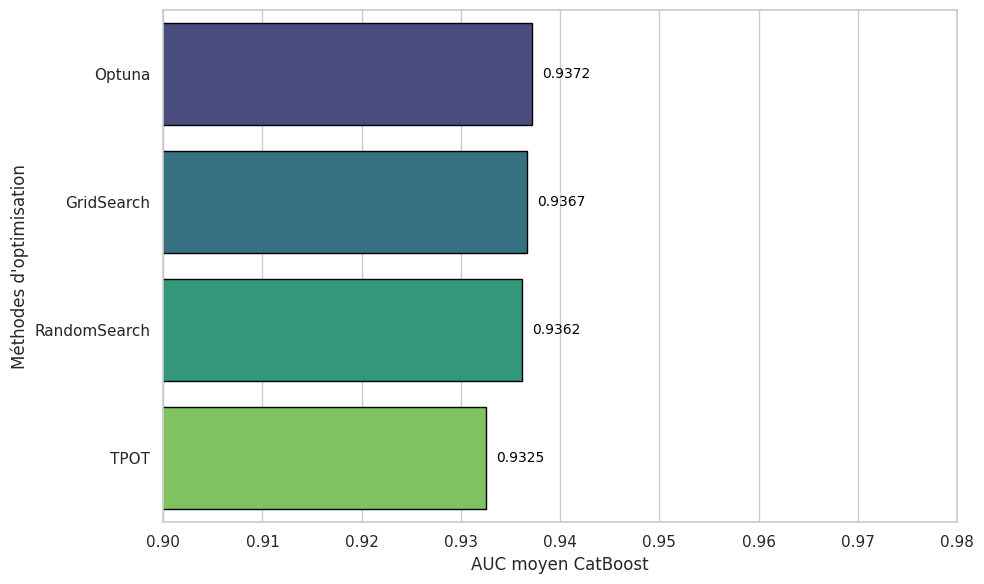

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Données
methods = ['Optuna', 'GridSearch', 'RandomSearch', 'TPOT']
auc_scores = [0.9372, 0.9367, 0.9362, 0.9325]

# Initialisation de la figure
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Créer un barplot horizontal avec la palette viridis
ax = sns.barplot(x=auc_scores, y=methods, palette='viridis', edgecolor='black')

# Ajouter des labels et un titre
ax.set_xlabel('AUC moyen CatBoost', fontsize=12)
ax.set_ylabel('Méthodes d\'optimisation', fontsize=12)
#ax.set_title('Comparaison des méthodes d\'optimisation pour CatBoost', fontsize=14, weight='bold')

# Ajuster les limites de l'axe X
ax.set_xlim(0.9, 0.98)

# Ajouter les valeurs des AUC sur les barres
for i, v in enumerate(auc_scores):
    ax.text(v + 0.001, i, f"{v:.4f}", color='black', va='center', fontsize=10)

# Afficher le graphique
plt.tight_layout()
plt.show()
